In [8]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, hierarchical_inference
from matplotlib.lines import Line2D
import corner
import pandas as pd
import numpy as np
from lenstronomy.Util.param_util import ellipticity2phi_q

# This allows you to modify the paths in the config to agree with the path you're using
def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating Hierarchical Inference Plots

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 07/03/2020

__Goals:__ Generate all of the hierarchical inference plots used in the paper analysis.

__Before running this notebook:__ You will have to download and unzip the bnn samples, chains, and datasets that cound be found here (TODO). Because we already have the BNN samples, the model weights are not neccesary. If you would like to reproduce these results starting from the model weights, see the demo notebook on hierarchical inference.

## Create a corner plot to compare training and test distributions

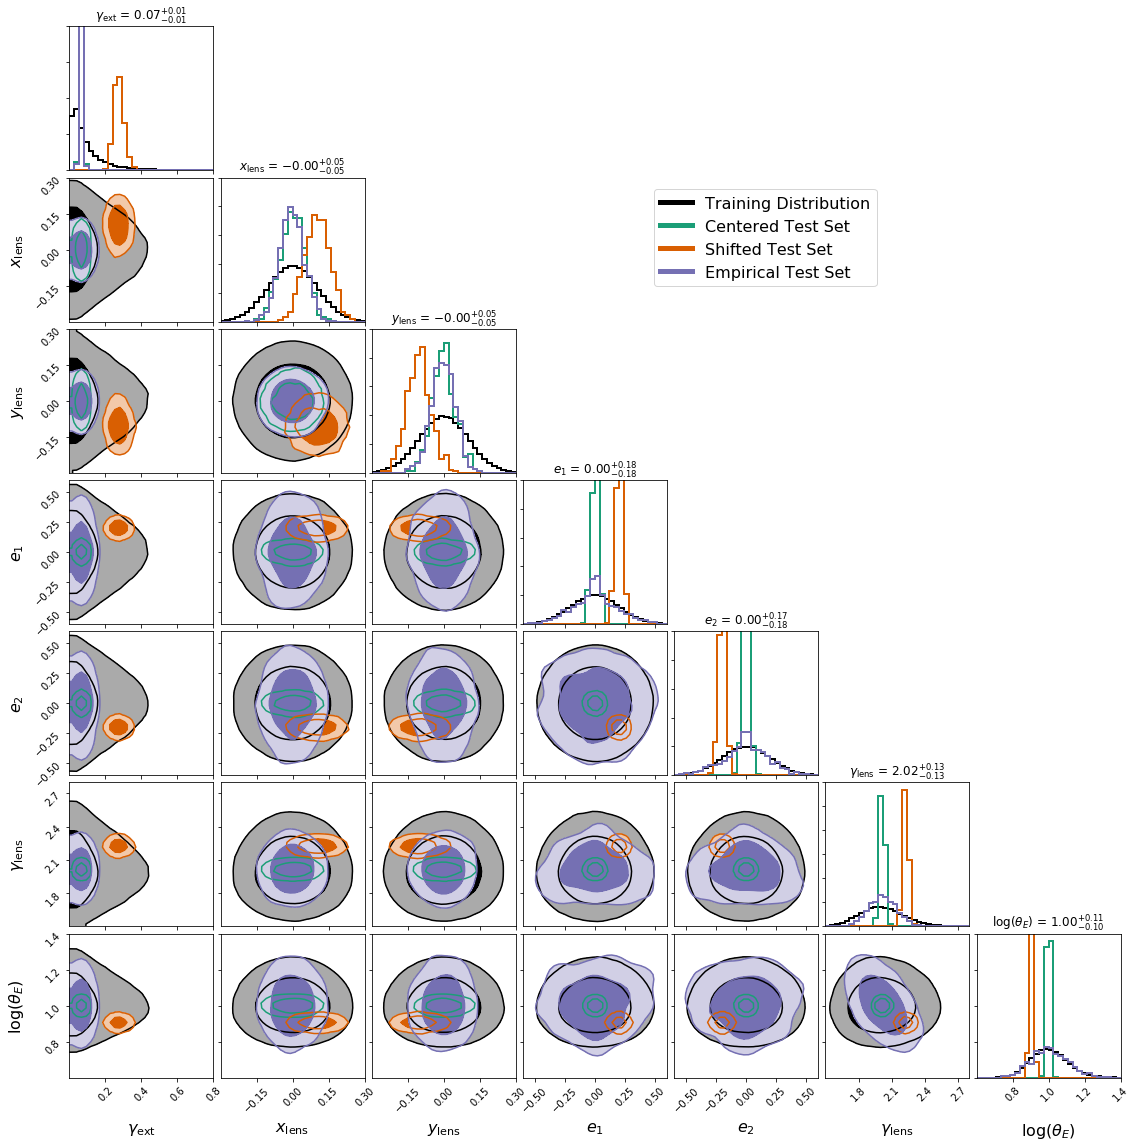

Percent of Training Points in Centered Test Set:  0.14425
Number of Training Points in Centered Test Set:  577
Percent of Training Points in Shifted Test Set:  0.0055000000000000005
Number of Training Points in Shifted Test Set:  22
Percent of Training Points in Empirical Test Set:  18.272
Number of Training Points in Empirical Test Set:  73088


In [9]:
# Load each one of the metadatas to compare the corner plots
root_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/'
train_metadata = pd.read_csv(root_path+'datasets/train/metadata.csv')
cn_metadata = pd.read_csv(root_path+'datasets/cent_narrow/metadata.csv')
sn_metadata = pd.read_csv(root_path+'datasets/shifted_narrow/metadata.csv')
emp_metadata = pd.read_csv(root_path+'datasets/empirical/metadata.csv')

# Specify the lens_params we're interested in
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
lens_params = cfg['dataset_params']['lens_params']
final_params_print_names = cfg['inference_params']['final_params_print_names']
final_params_print_names.pop(lens_params.index('external_shear_psi_ext'))
final_params_print_names[0] = r'$\gamma_\mathrm{ext}$'
lens_params.pop(lens_params.index('external_shear_psi_ext'))

# Get the samples in numpy format
train_samps = train_metadata[lens_params].to_numpy()
cn_samps = cn_metadata[lens_params].to_numpy()
sn_samps = sn_metadata[lens_params].to_numpy()
emp_samps = emp_metadata[lens_params].to_numpy()

# Generate the plot
figure= None
color_map = ['000000','#1b9e77','#d95f02','#7570b3']
plot_limits = [[0,0.8],[-0.3,0.3],[-0.3,0.3],[-0.6,0.6],[-0.6,0.6],[1.5,2.8],[0.6,1.4]]
hist_limit = [20,10,10,10,10,15,20]
smooth = 0.8
fontsize = 16
hist_kwargs = {'density':True,'color':color_map[0],'lw':2}
figure = corner.corner(train_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[0],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map[1]
figure = corner.corner(cn_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[1],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map[2]
figure = corner.corner(sn_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[2],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map[3]
figure = corner.corner(emp_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[3],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth*2,hist_kwargs=hist_kwargs)
handles = [Line2D([0], [0], color=color_map[0], lw=5),
           Line2D([0], [0], color=color_map[1], lw=5),
           Line2D([0], [0], color=color_map[2], lw=5),
           Line2D([0], [0], color=color_map[3], lw=5)]
figure.legend(handles,[r'Training Distribution', r'Centered Test Set',r'Shifted Test Set',r'Empirical Test Set'],
              loc=(0.575,0.75),fontsize=fontsize)

axes = np.array(figure.axes).reshape((len(lens_params),len(lens_params)))
for i in range(len(lens_params)):
    axes[i,i].set_ylim(0,hist_limit[i])
    
plt.savefig('figures/distribution_comp.pdf')
plt.show()

print('Percent of Training Points in Centered Test Set: ',
      np.mean(np.prod((train_samps > np.min(cn_samps,axis=0)) * (train_samps < np.max(cn_samps,axis=0)),axis=1))*100)
print('Number of Training Points in Centered Test Set: ',
      np.sum(np.prod((train_samps > np.min(cn_samps,axis=0)) * (train_samps < np.max(cn_samps,axis=0)),axis=1)))
print('Percent of Training Points in Shifted Test Set: ',
      np.mean(np.prod((train_samps > np.min(sn_samps,axis=0)) * (train_samps < np.max(sn_samps,axis=0)),axis=1))*100)
print('Number of Training Points in Shifted Test Set: ',
      np.sum(np.prod((train_samps > np.min(sn_samps,axis=0)) * (train_samps < np.max(sn_samps,axis=0)),axis=1)))
print('Percent of Training Points in Empirical Test Set: ',
      np.mean(np.prod((train_samps > np.min(emp_samps,axis=0)) * (train_samps < np.max(emp_samps,axis=0)),axis=1))
      *100)
print('Number of Training Points in Empirical Test Set: ',
      np.sum(np.prod((train_samps > np.min(emp_samps,axis=0)) * (train_samps < np.max(emp_samps,axis=0)),axis=1)))


## Compare performance of all three model types on the centered narrow test distribution

First, we start by loading the files we'll need for our analysis

In [34]:
# Here we'll define a few lists we'll use throughout plotting
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\log (\gamma_\mathrm{lens})}$',r'$\sigma_{\log (\gamma_\mathrm{lens})}$',
                         r'$\mu_{\log (\theta_E)}$',r'$\sigma_{\log (\theta_E)}$']
param_plot_names = [r'$\gamma_\mathrm{ext}$', r'$\psi_\mathrm{ext}$',r'$x_\mathrm{lens}$',
            r'$y_\mathrm{lens}$',r'$e_1$',r'$e_2$',r'$\gamma_\mathrm{lens}$',r'$\theta_E$']

In [27]:
# Diagonal model 30% dropout chains on centered test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/cent_narrow_cfg_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/cent_narrow.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_cn'
num_samples = 1000
n_walkers = 50

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn1 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)

# We can load the chains for nn1_hr on the centered narrow distribution
save_path_samples_nn1_hr = root_path + 'hierarchical_results/cn_nn1_hr_samps/'
hier_infer_nn1.gen_samples(num_samples,save_path_samples_nn1_hr)
# Same goes for the samples
n_walkers = 50
save_path_chains_nn1_hr = root_path + 'hierarchical_results/cn_nn1_hr.h5'
hier_infer_nn1.initialize_sampler(n_walkers,save_path_chains_nn1_hr)

# Repeat this process for our remaining two distributions
# Full Model 0.1% Dropout
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn2 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn2_slr = root_path + 'hierarchical_results/cn_nn2_slr_samps/'
hier_infer_nn2.gen_samples(num_samples,save_path_samples_nn2_slr)
save_path_chains_nn2_slr = root_path + 'hierarchical_results/cn_nn2_slr.h5'
hier_infer_nn2.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn2_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn2_slr_samps/
Loading samples from /Users/sebwagner/Doc

We can quickly check that each of our chains are converged. These lines are commented out to avoid extending the length of notebook, but you should run them at least once to convince yourself the chains are converged!

In [12]:
burnin = 8000
# hier_infer_nn1.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn1.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn2.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn2.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

Our main parameter of interest is the power-law mass slope so we'll focus on that for the posteriors of the centered narrow distribution. First we generate the 1D plots for our three models.

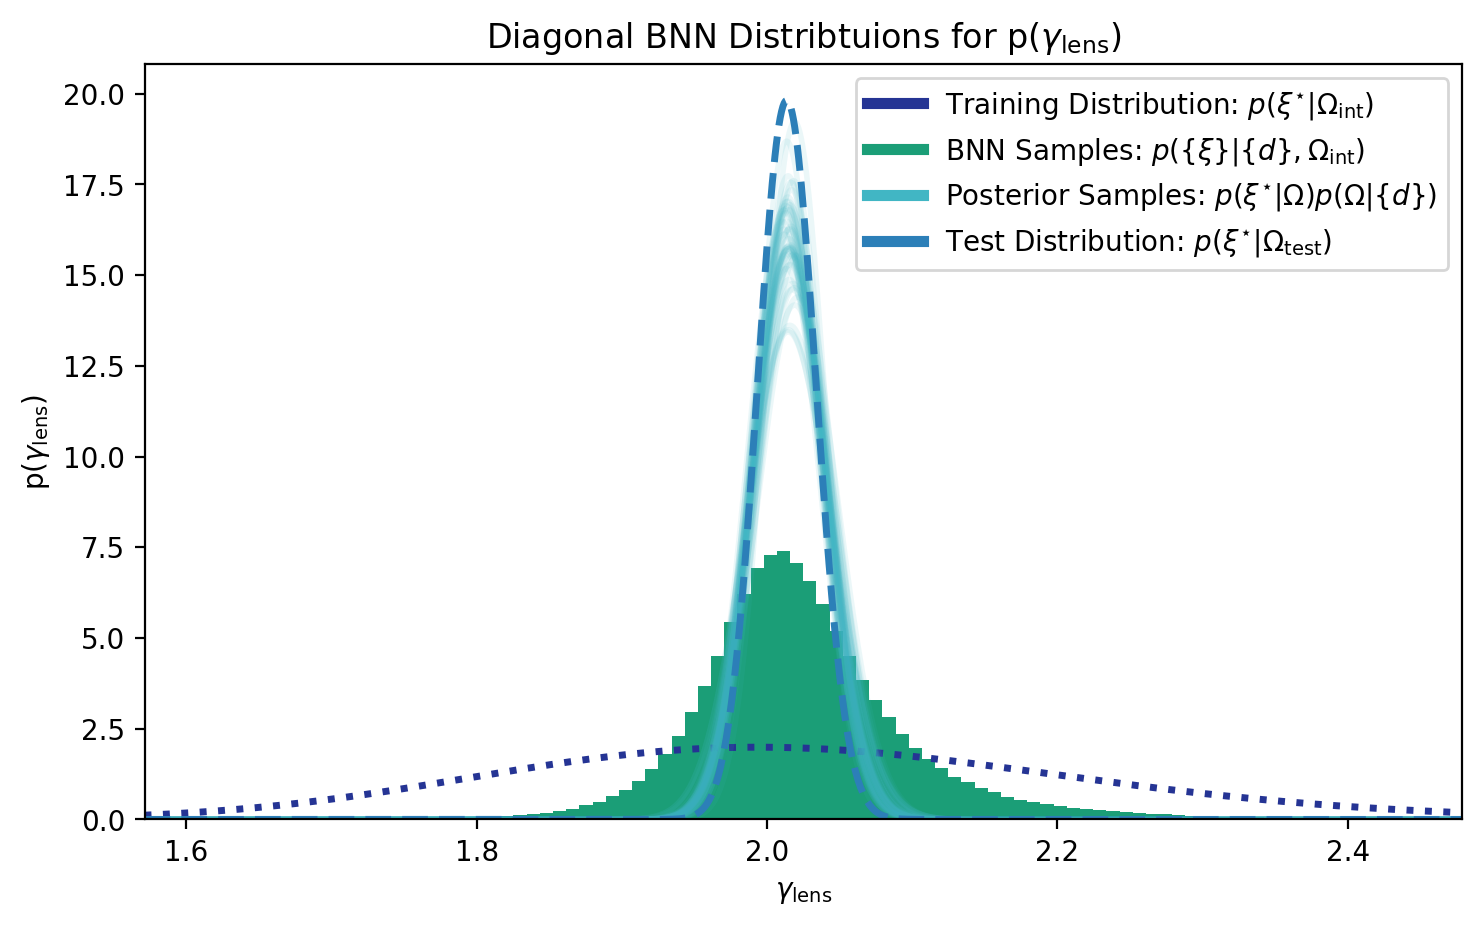

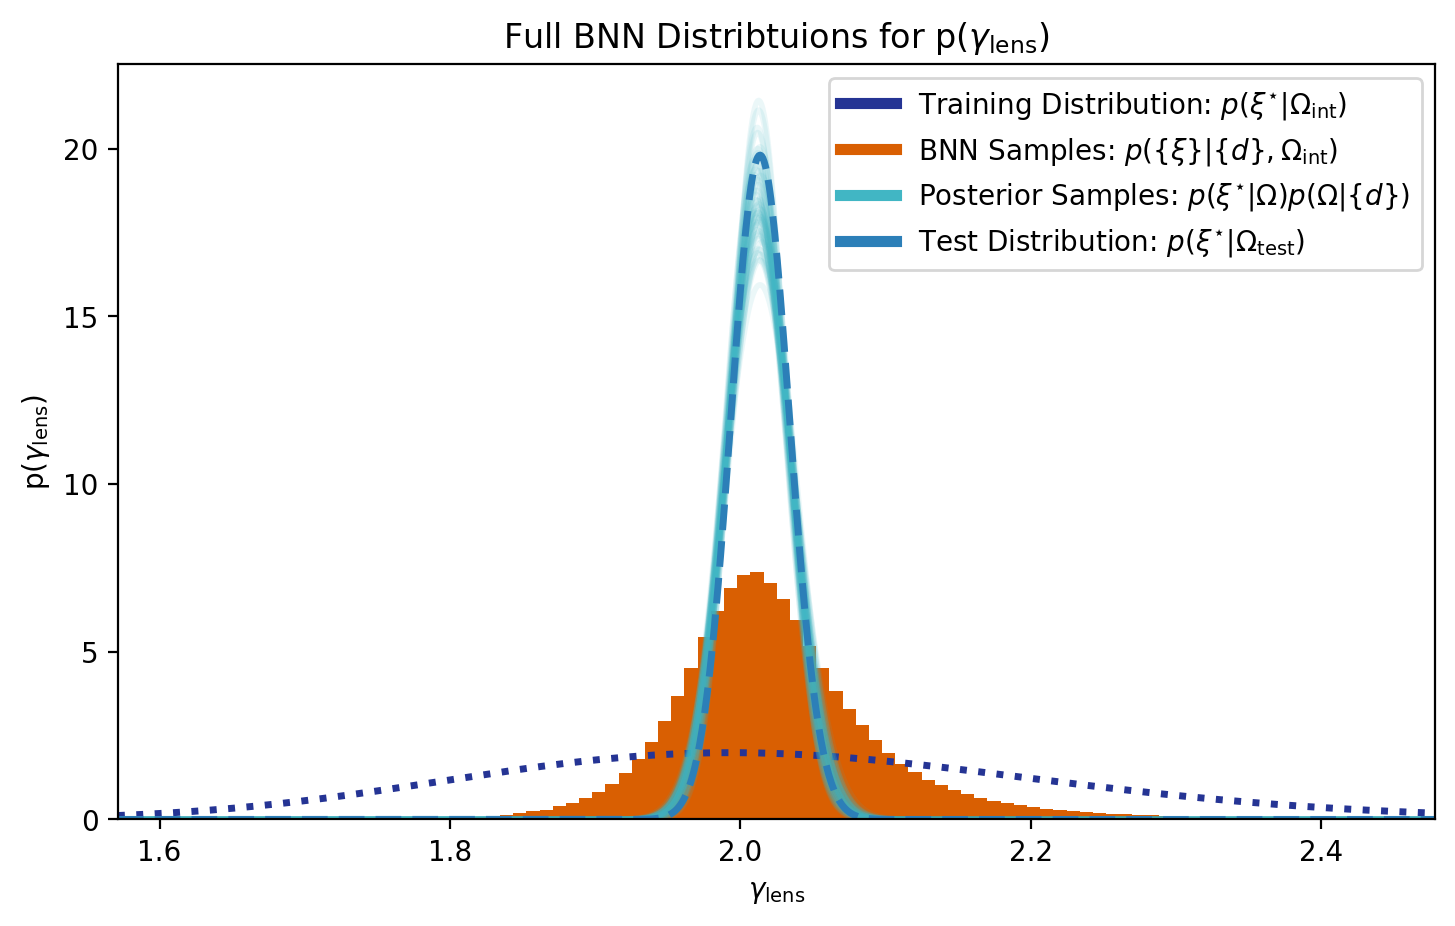

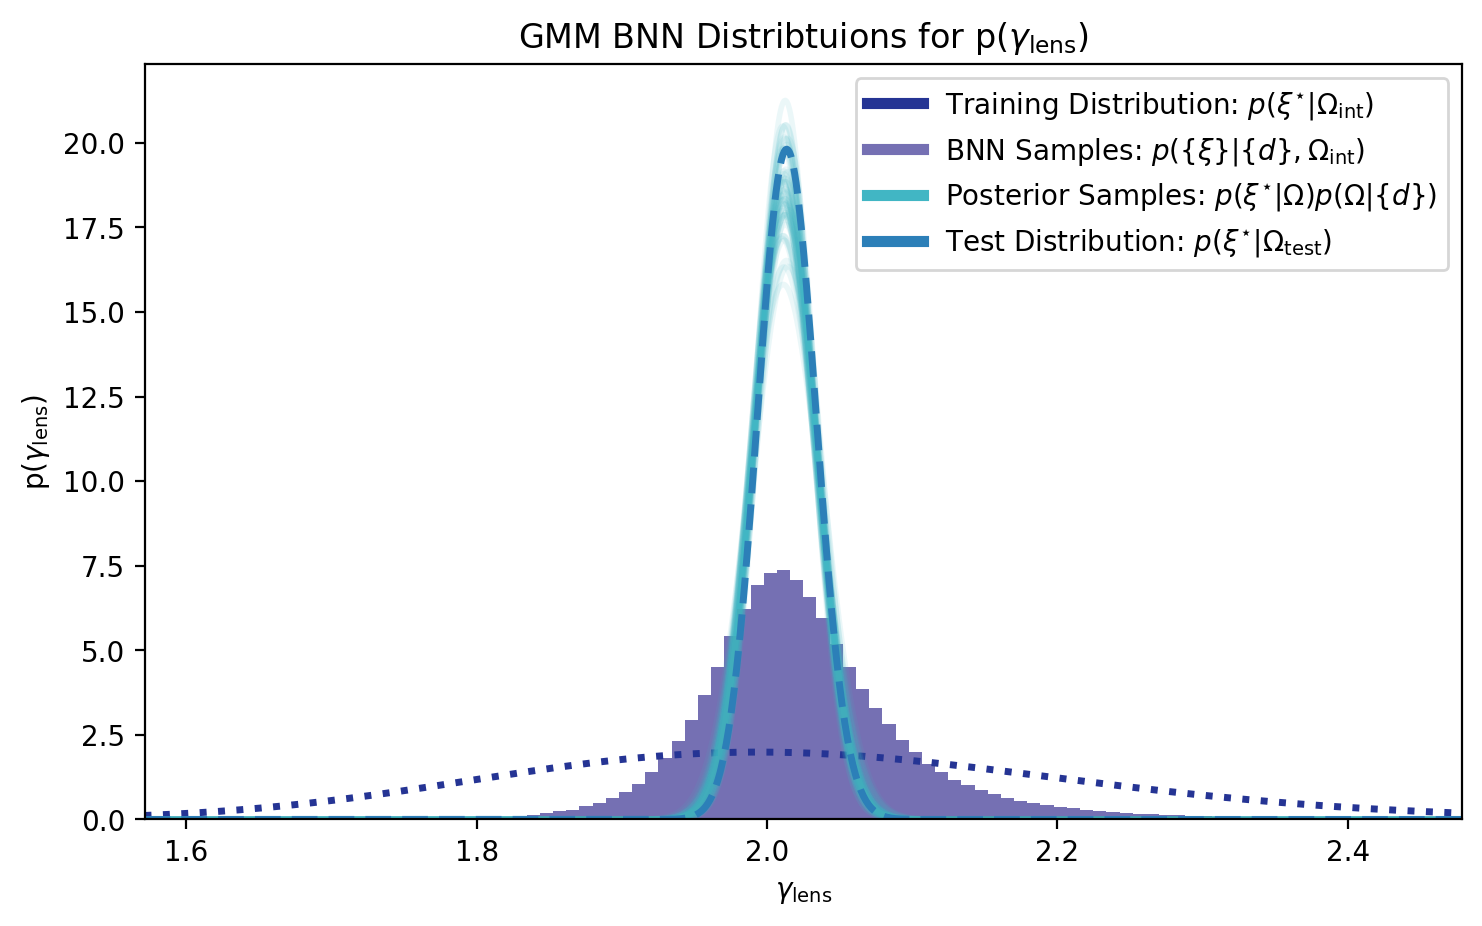

In [13]:
color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
bnn_name = 'Diagonal BNN'
save_fig_path = 'figures/cn_gamma_lens_1d_diag.pdf'
hier_infer_nn1.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#d95f02"
bnn_name = 'Full BNN'
save_fig_path = 'figures/cn_gamma_lens_1d_full.pdf'
hier_infer_nn2.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#7570b3" 
bnn_name = 'GMM BNN'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm.pdf'
hier_infer_nn3.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

Together with the 1d distributions, we may also be interested in comparing the posteriors for the two hyperparameters we've inferred hierarchically for gamma lens.

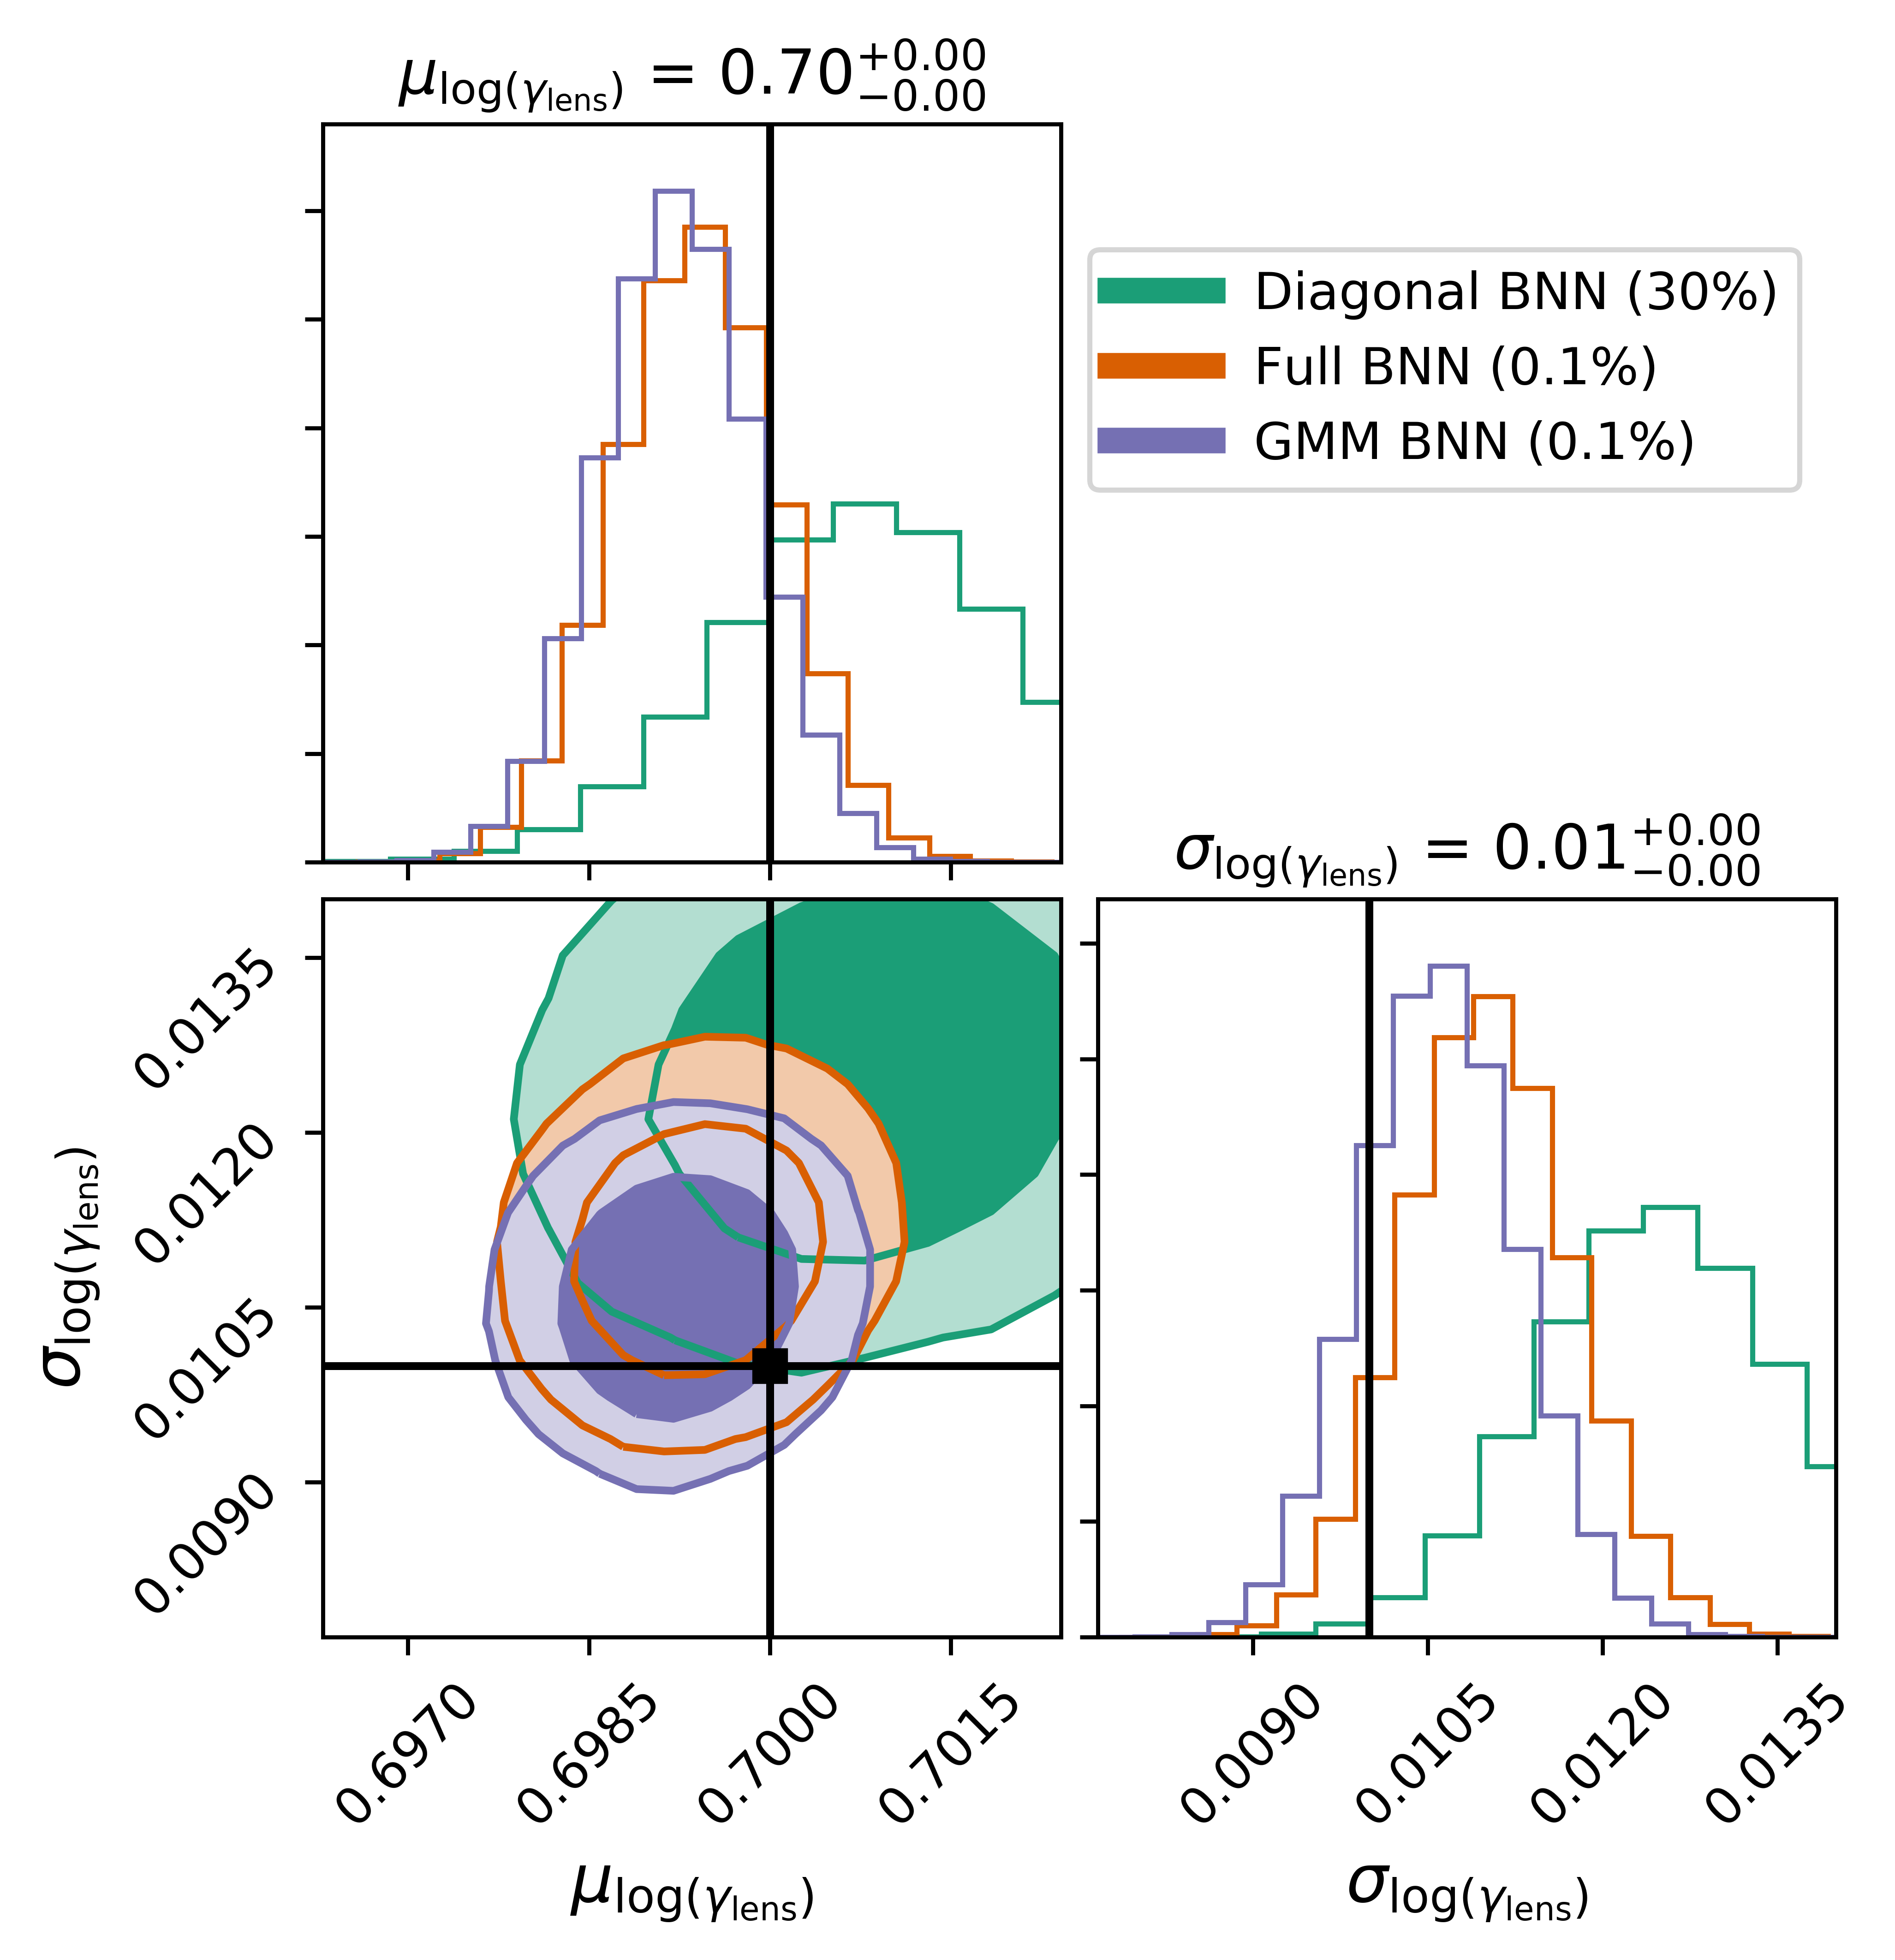

In [14]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
figure = hier_infer_nn1.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77')
figure = hier_infer_nn2.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure)
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/cn_gamma_lens_2d_hyps.pdf')
plt.show(figure)

## Compare performance of all three model types on the shifted narrow test distribution

In [28]:
# Diagonal model 30% dropout chains on shifted test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/shifted_narrow_cfg_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/shifted_narrow.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/shifted_narrow/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_sn'

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn1 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn1_hr = root_path + 'hierarchical_results/sn_nn1_hr_samps/'
hier_infer_nn1.gen_samples(num_samples,save_path_samples_nn1_hr)
save_path_chains_nn1_hr = root_path + 'hierarchical_results/sn_nn1_hr.h5'
hier_infer_nn1.initialize_sampler(n_walkers,save_path_chains_nn1_hr)

# Repeat this process for our remaining two distributions
# Full Model 0.1% Dropout
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn2 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn2_slr = root_path + 'hierarchical_results/sn_nn2_slr_samps/'
hier_infer_nn2.gen_samples(num_samples,save_path_samples_nn2_slr)
save_path_chains_nn2_slr = root_path + 'hierarchical_results/sn_nn2_slr.h5'
hier_infer_nn2.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/sn_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/sn_nn3_slr.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/shifted_narrow/tf_record_sn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn1_hr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn1_hr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn1_hr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn2_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/shifted_narrow/tf_record_sn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn2_slr_samps/
Loading samples from /Users/sebwagn

Check that the chains have converged.

In [29]:
burnin = 8000
# hier_infer_nn1.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn1.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn2.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn2.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

As before, our main parameter of interest is the power-law mass slope.

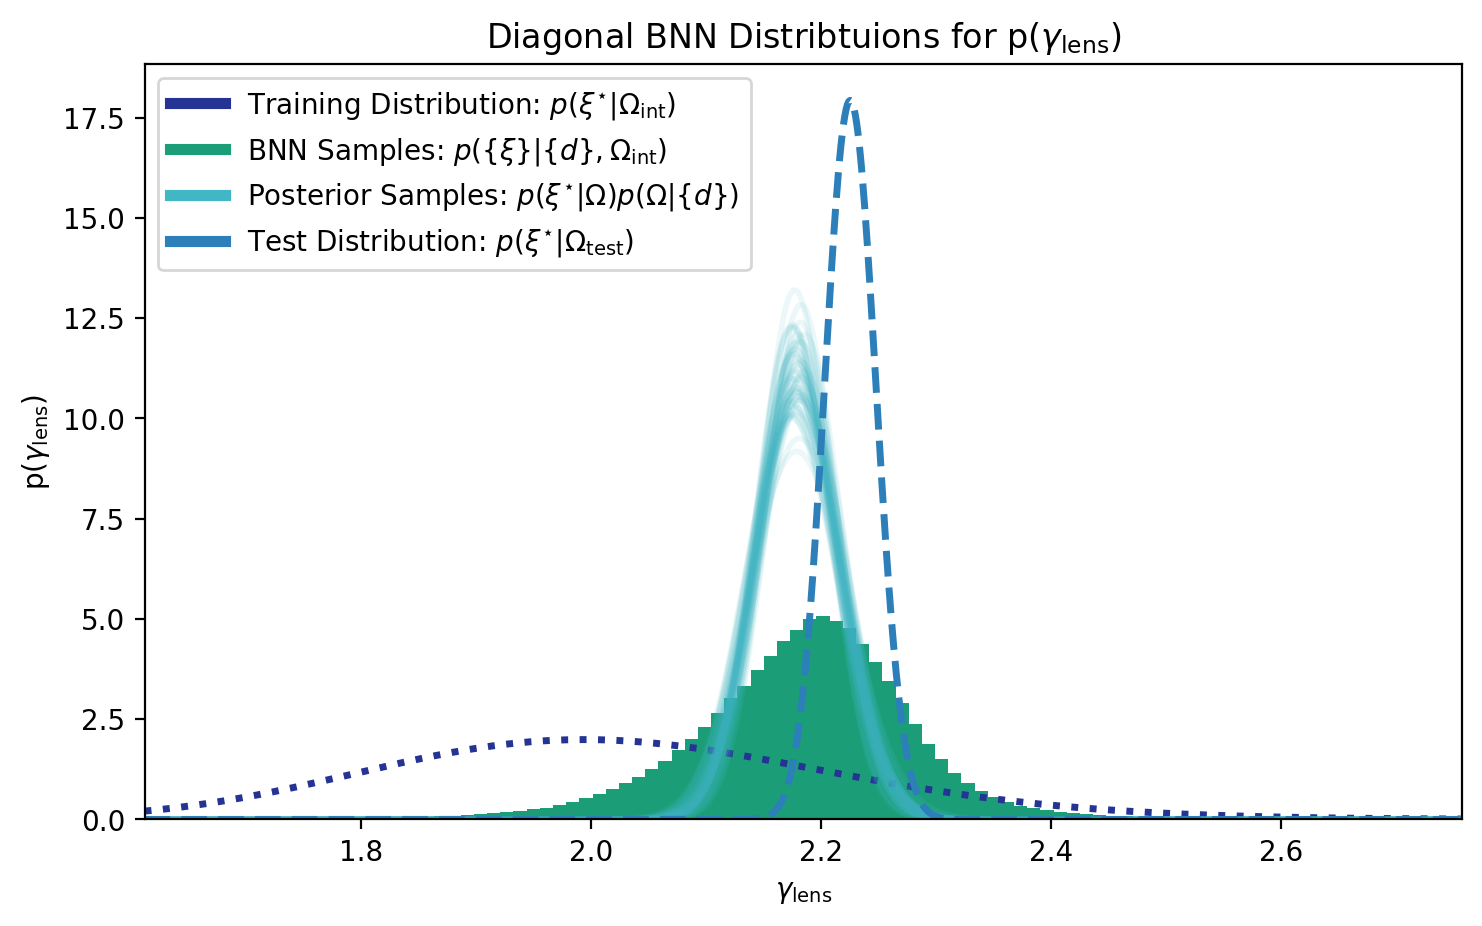

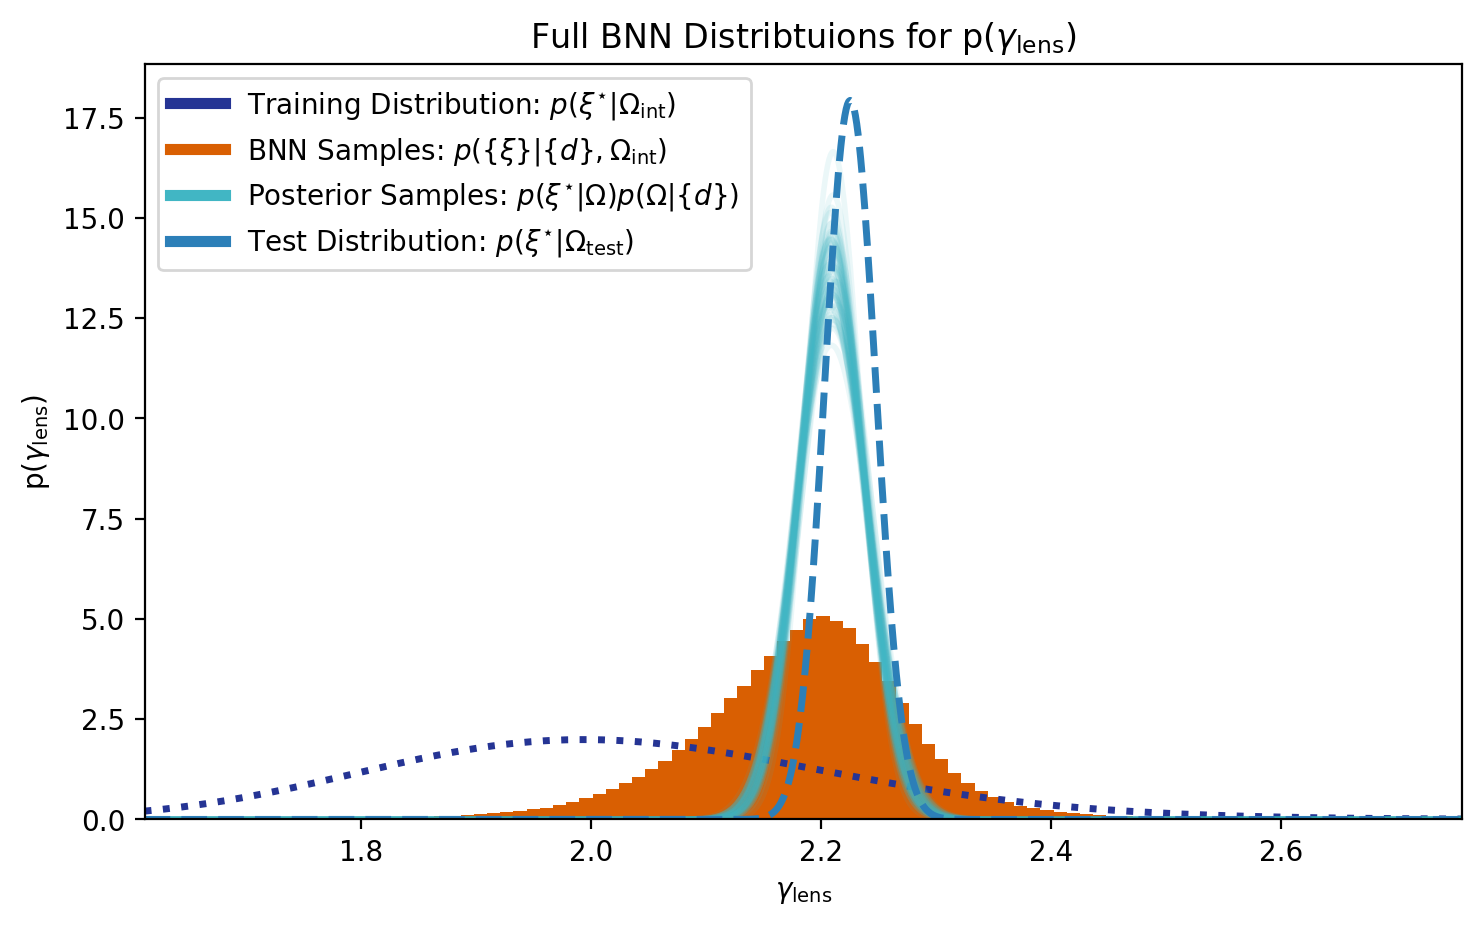

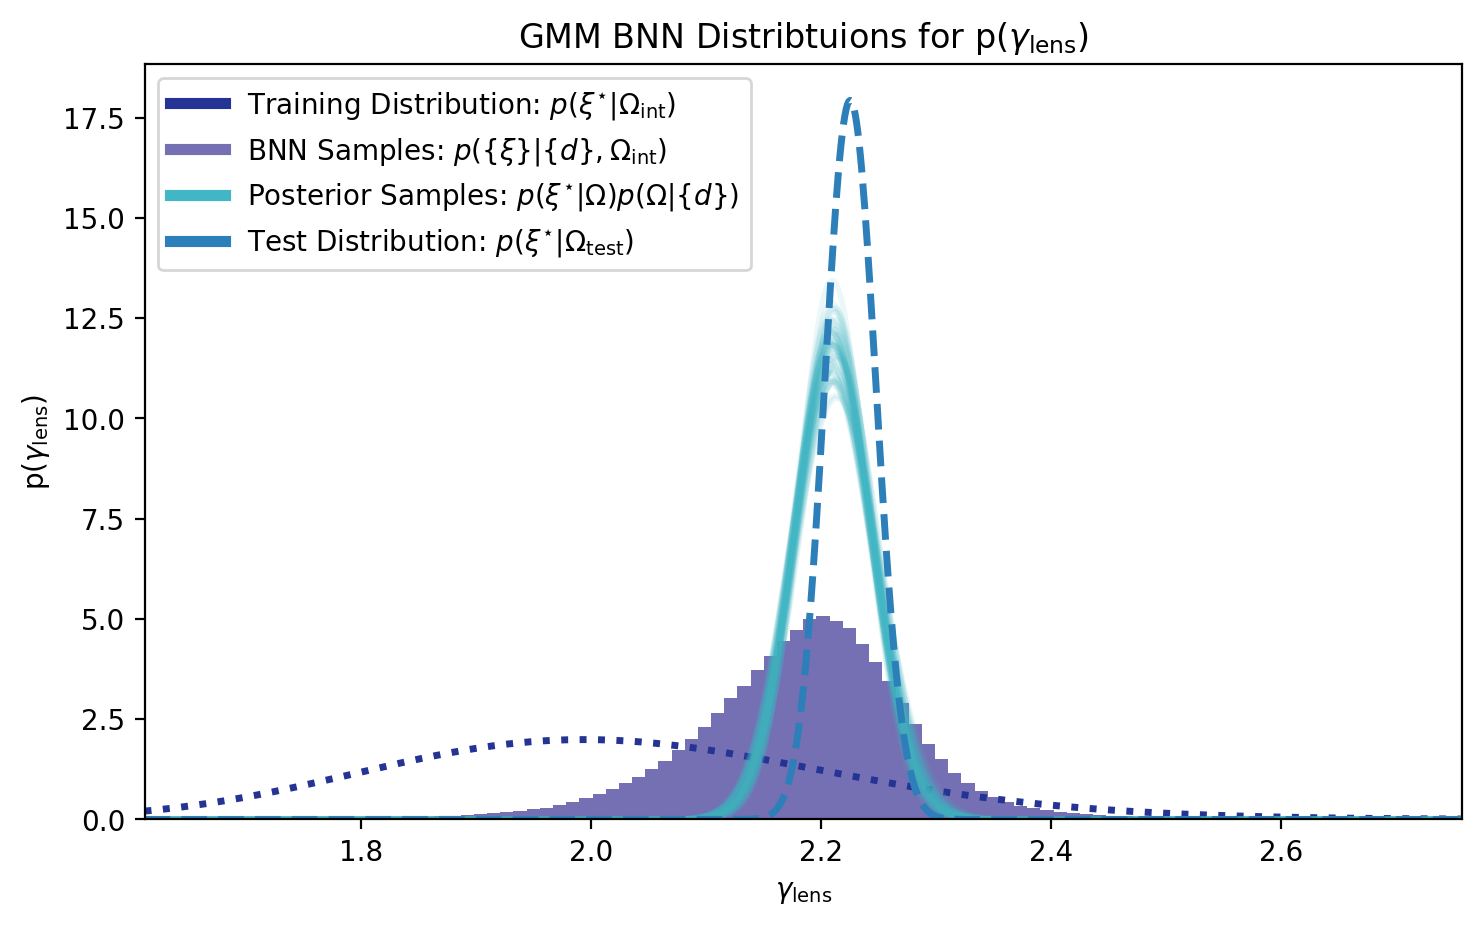

In [30]:
color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
bnn_name = 'Diagonal BNN'
save_fig_path = 'figures/sn_gamma_lens_1d_diag.pdf'
hier_infer_nn1.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#d95f02"
bnn_name = 'Full BNN'
save_fig_path = 'figures/sn_gamma_lens_1d_full.pdf'
hier_infer_nn2.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#7570b3" 
bnn_name = 'GMM BNN'
save_fig_path = 'figures/sn_gamma_lens_1d_gmm.pdf'
hier_infer_nn3.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

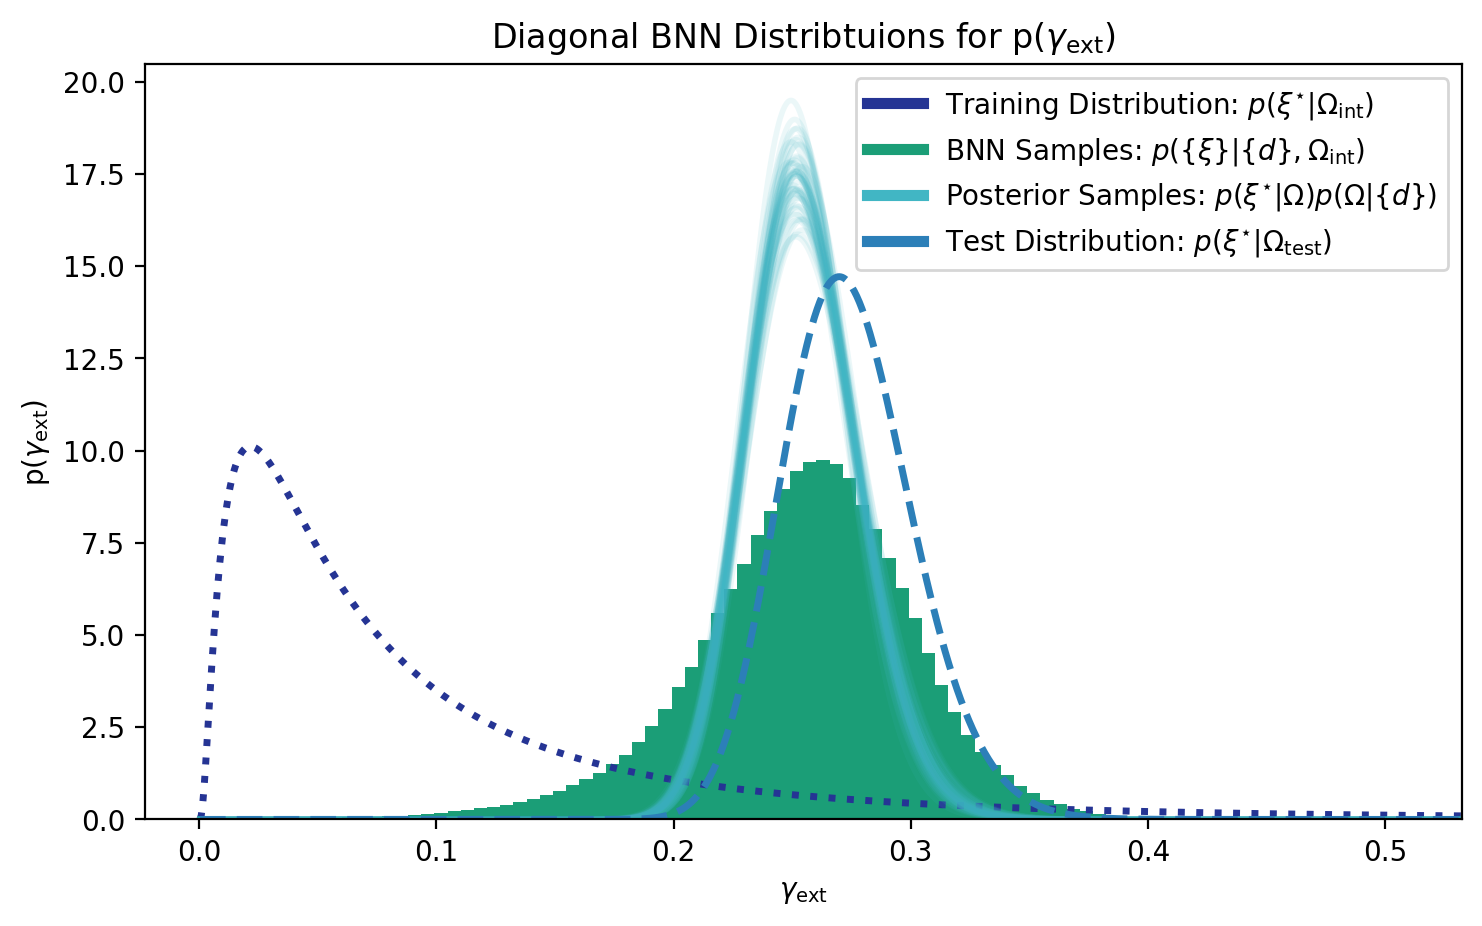

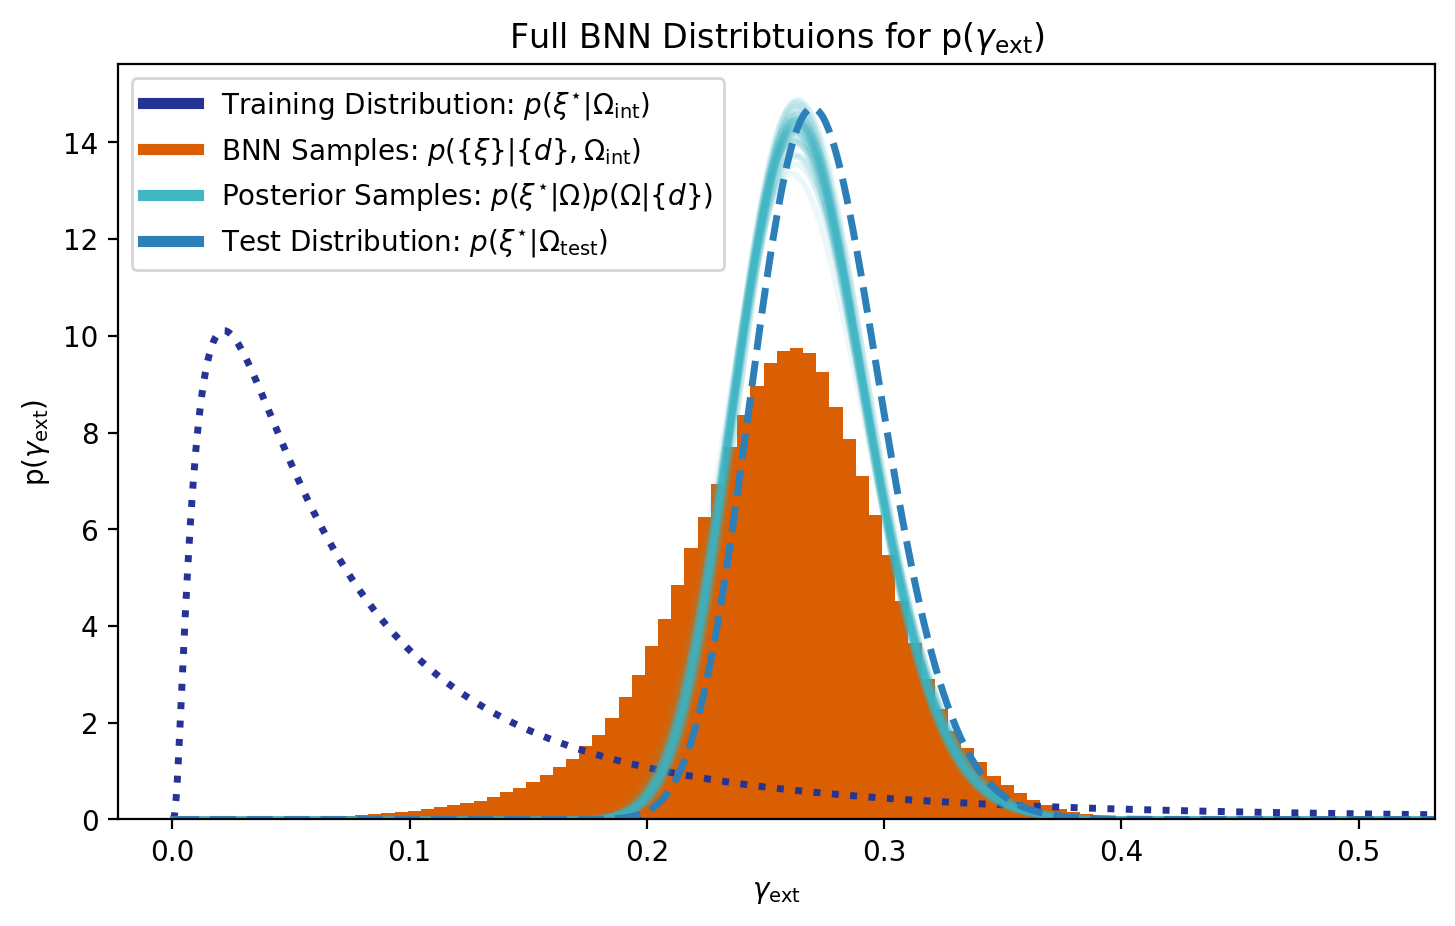

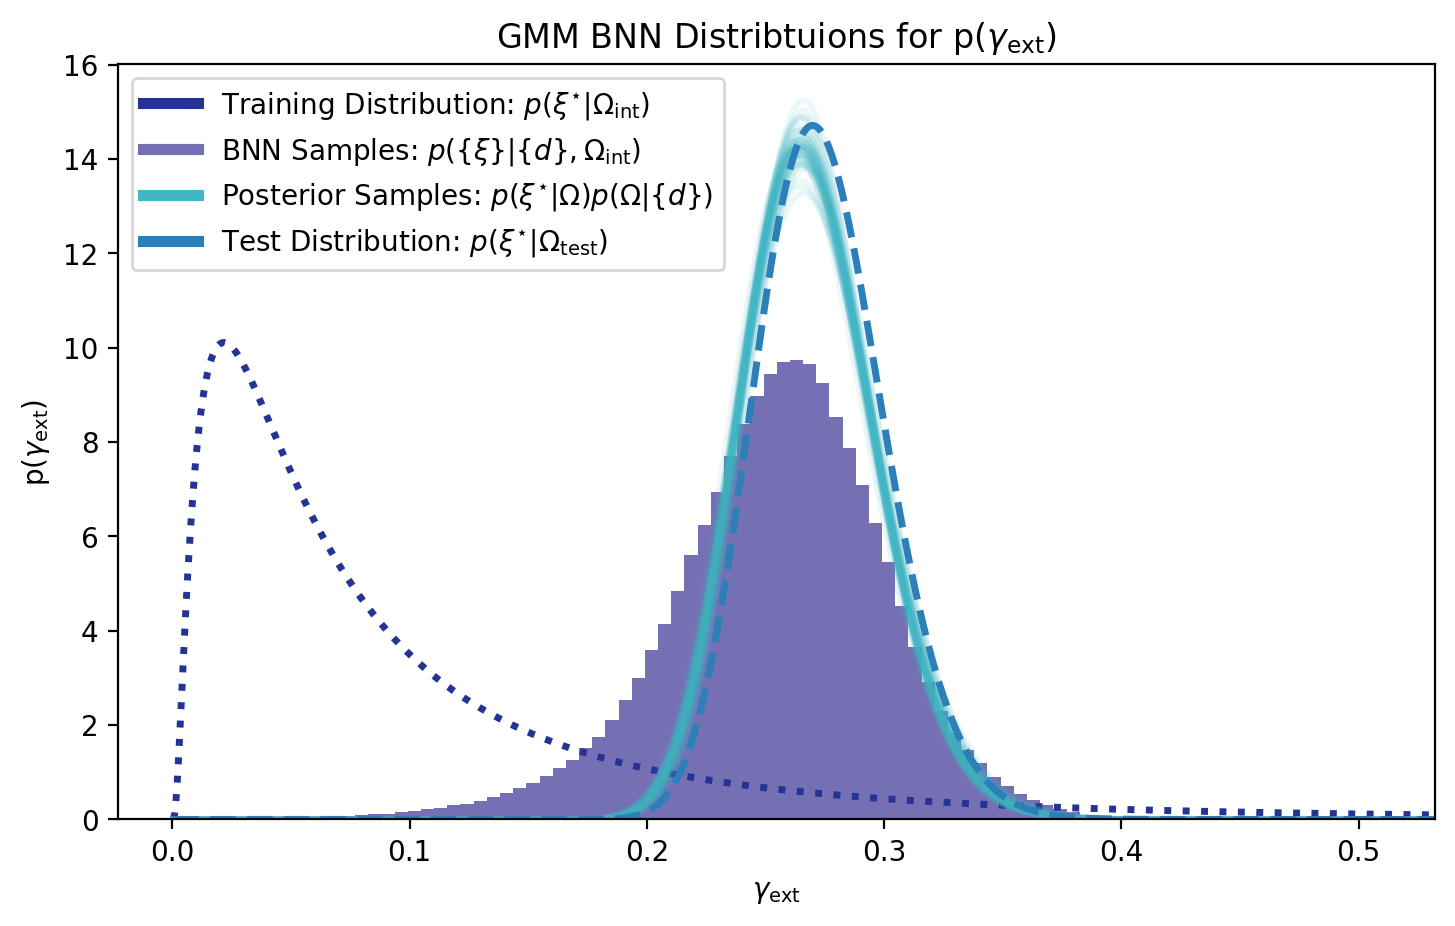

In [31]:
color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
bnn_name = 'Diagonal BNN'
save_fig_path = 'figures/cn_gamma_lens_1d_diag.pdf'
hier_infer_nn1.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='external_shear_gamma_ext',save_fig_path=save_fig_path)

color_map[1] = "#d95f02"
bnn_name = 'Full BNN'
save_fig_path = 'figures/cn_gamma_lens_1d_full.pdf'
hier_infer_nn2.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='external_shear_gamma_ext',save_fig_path=save_fig_path)

color_map[1] = "#7570b3" 
bnn_name = 'GMM BNN'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm.pdf'
hier_infer_nn3.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='external_shear_gamma_ext',save_fig_path=save_fig_path)

Given that the shifted distribution involves a ~3 sigma shift, our hierarchical reconstruction goes surprisingly well. It's worth looking at the same 2d contours as before to compare our models.

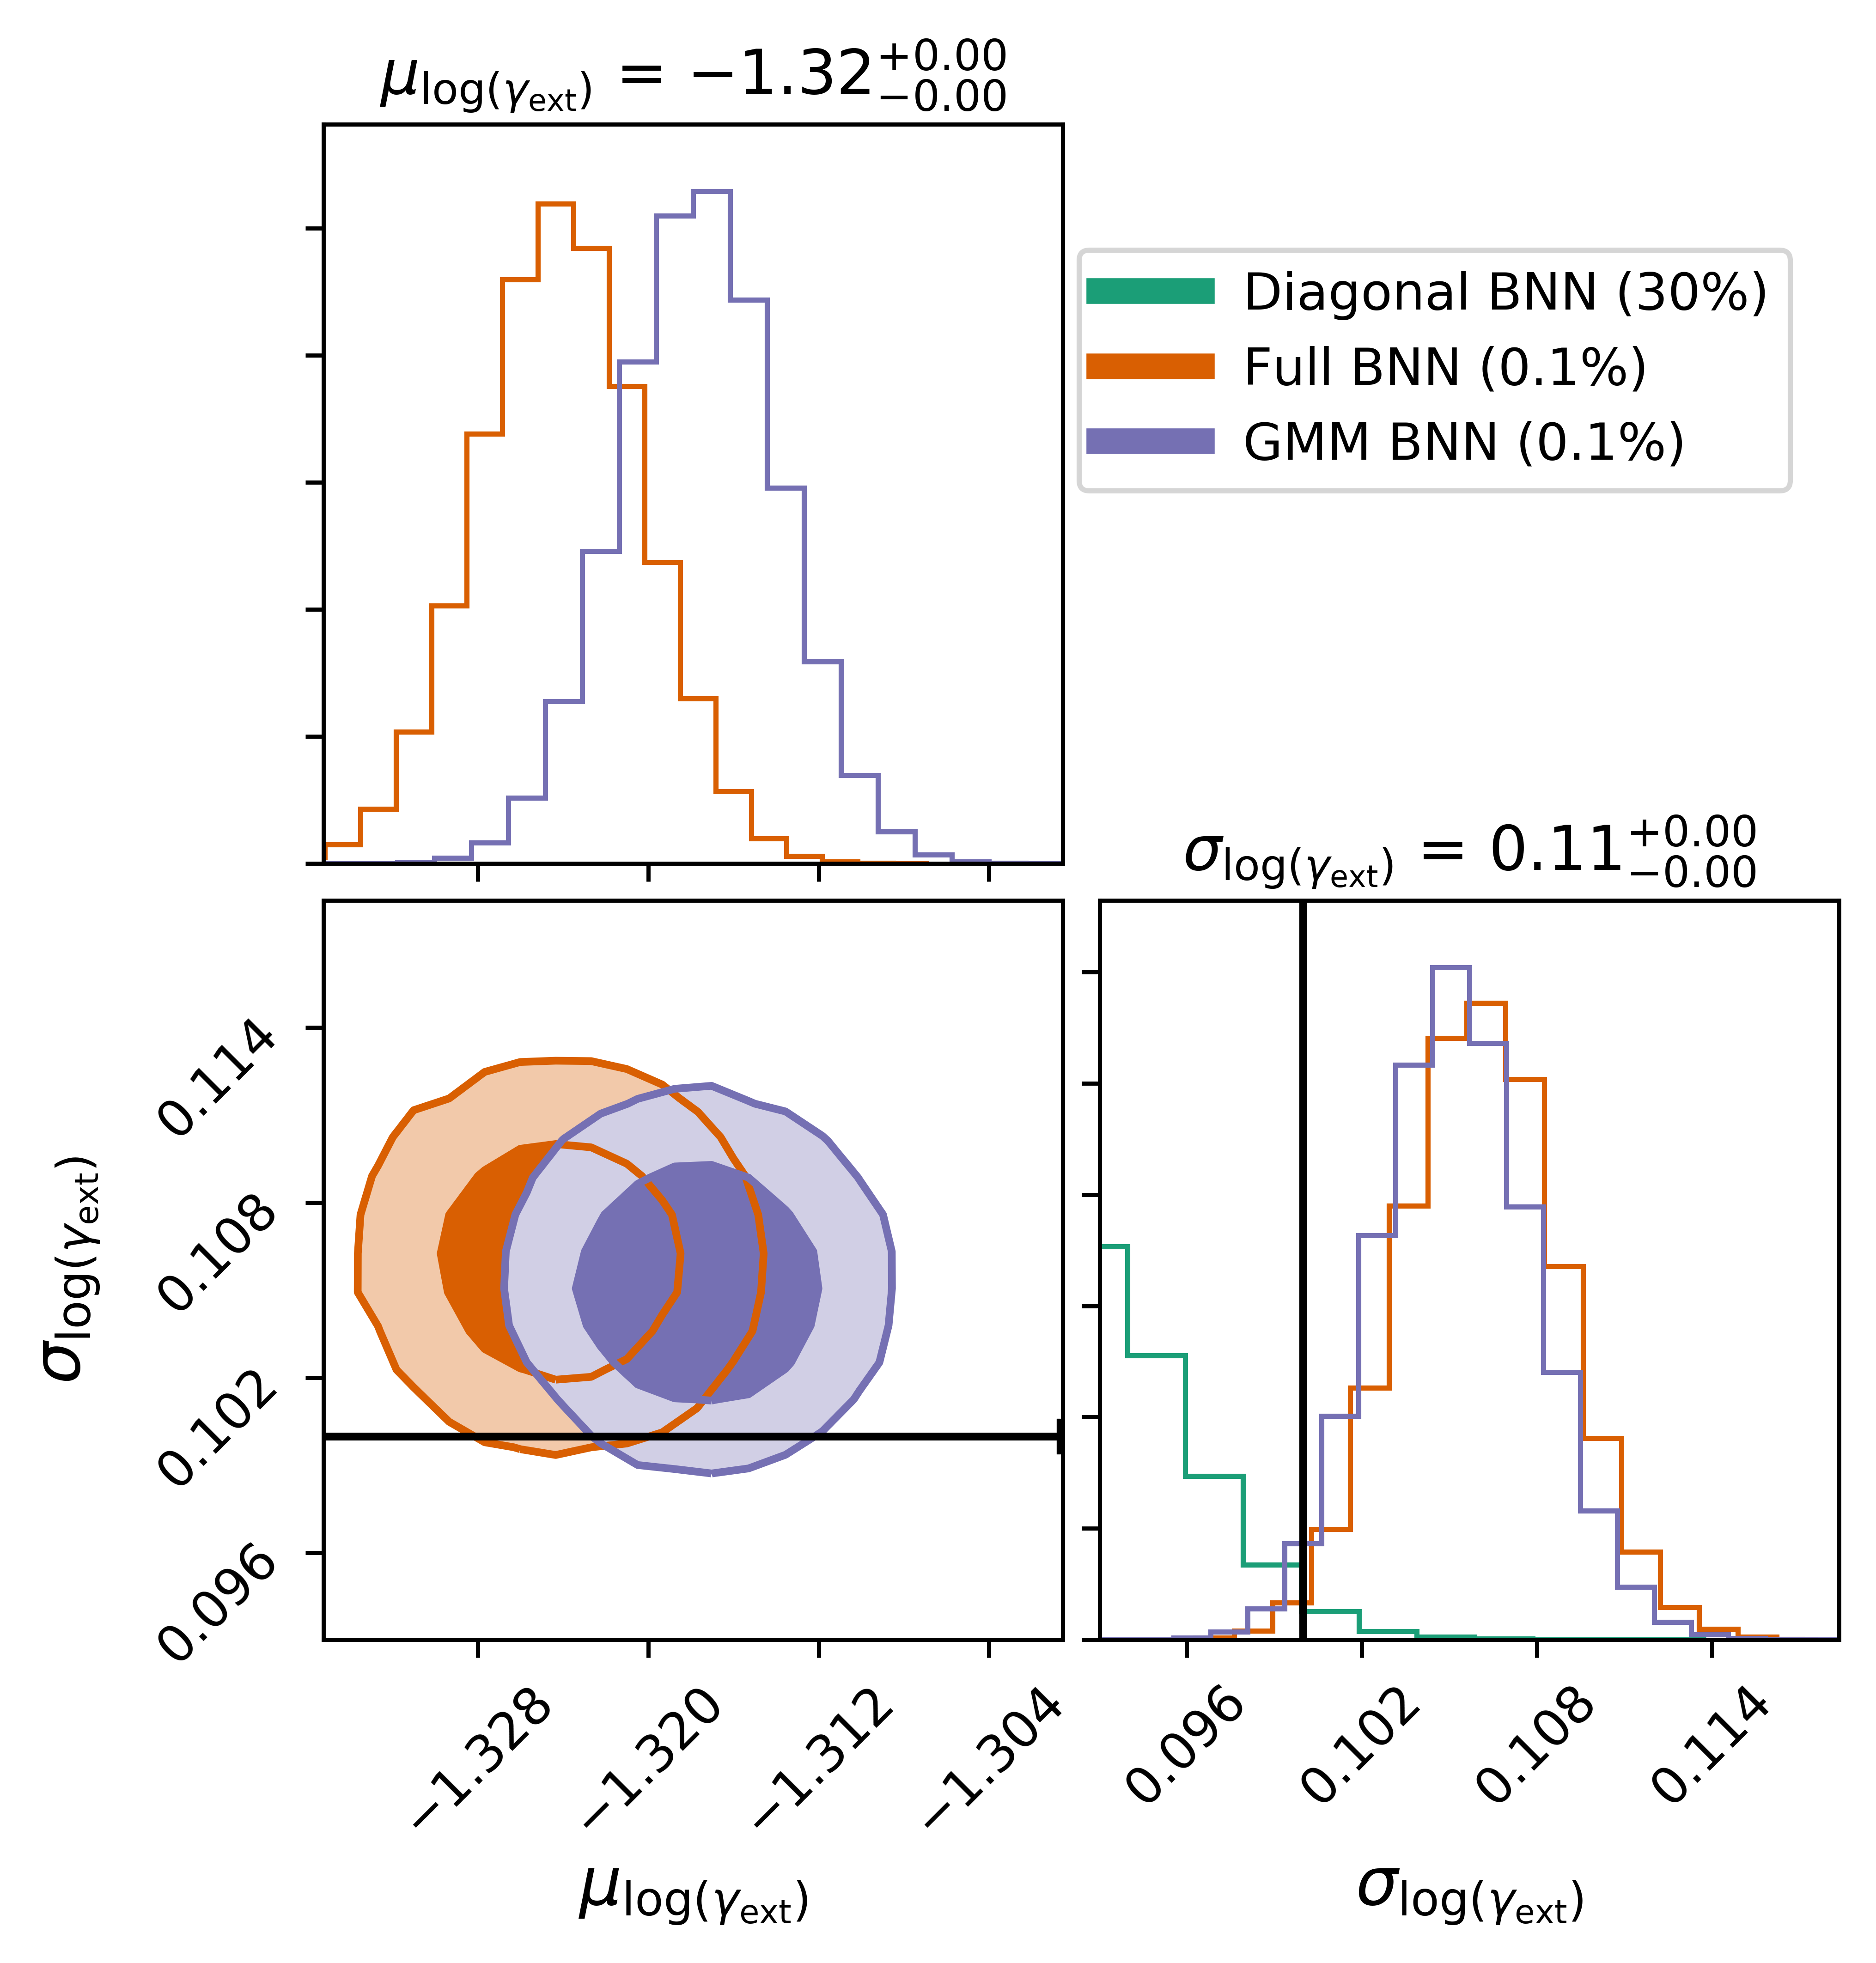

In [35]:
# Plot the two contours with the truth
plot_param = 'external_shear_gamma_ext'
plot_range = None#[[0.77,0.802],[0.009,0.02]]
figure = hier_infer_nn1.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=None)
figure = hier_infer_nn2.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/sn_gamma_lens_2d_hyps.pdf')
plt.show(figure)

In [33]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
plot_range = [[0.77,0.802],[0.009,0.02]]
figure = hier_infer_nn1.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn2.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/sn_gamma_lens_2d_hyps.pdf')
plt.show(figure)

ValueError: cannot reshape array of size 15400000 into shape (15)

## Compare performance of all three model types on the empirical test distribution

In [20]:
# Diagonal model 30% dropout chains on shifted test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/empirical_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/empirical.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_emp'
train_to_test_param_map = dict(orig_params=['lens_mass_e1','lens_mass_e2'],transform_func=ellipticity2phi_q,
                               new_params=['lens_mass_phi','lens_mass_q'])
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{\log(\theta_E)}$',r'$\mu_{\log(q_\mathrm{lens})}$',
                         r'$\mu_{\log(\gamma_\mathrm{lens})}$',r'$L_{00}$',r'$L_{10}$',r'$L_{11}$',r'$L_{20}$',
                         r'$L_{21}$',r'$L_{22}$']
# We used more walkers for the empirical distributions
n_walkers = 200

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn1 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path,
                                                             train_to_test_param_map=train_to_test_param_map)
save_path_samples_nn1_hr = root_path + 'hierarchical_results/emp_nn1_hr_samps/'
hier_infer_nn1.gen_samples(num_samples,save_path_samples_nn1_hr)
save_path_chains_nn1_hr = root_path + 'hierarchical_results/emp_nn1_hr.h5'
hier_infer_nn1.initialize_sampler(n_walkers,save_path_chains_nn1_hr)

# Repeat this process for our remaining two distributions
# Full Model 0.1% Dropout
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn2 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path,
                                                                train_to_test_param_map=train_to_test_param_map)
save_path_samples_nn2_slr = root_path + 'hierarchical_results/emp_nn2_slr_samps/'
hier_infer_nn2.gen_samples(num_samples,save_path_samples_nn2_slr)
save_path_chains_nn2_slr = root_path + 'hierarchical_results/emp_nn2_slr.h5'
hier_infer_nn2.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path,
                                                              train_to_test_param_map=train_to_test_param_map)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/emp_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/emp_nn3_slr.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/tf_record_emp
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn1_hr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn1_hr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn1_hr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn2_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/tf_record_emp
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn2_slr_samps/
Loading samples from /Users/sebwagner/D

In [21]:
burnin = 2000
# hier_infer_nn1.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn1.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn2.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn2.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

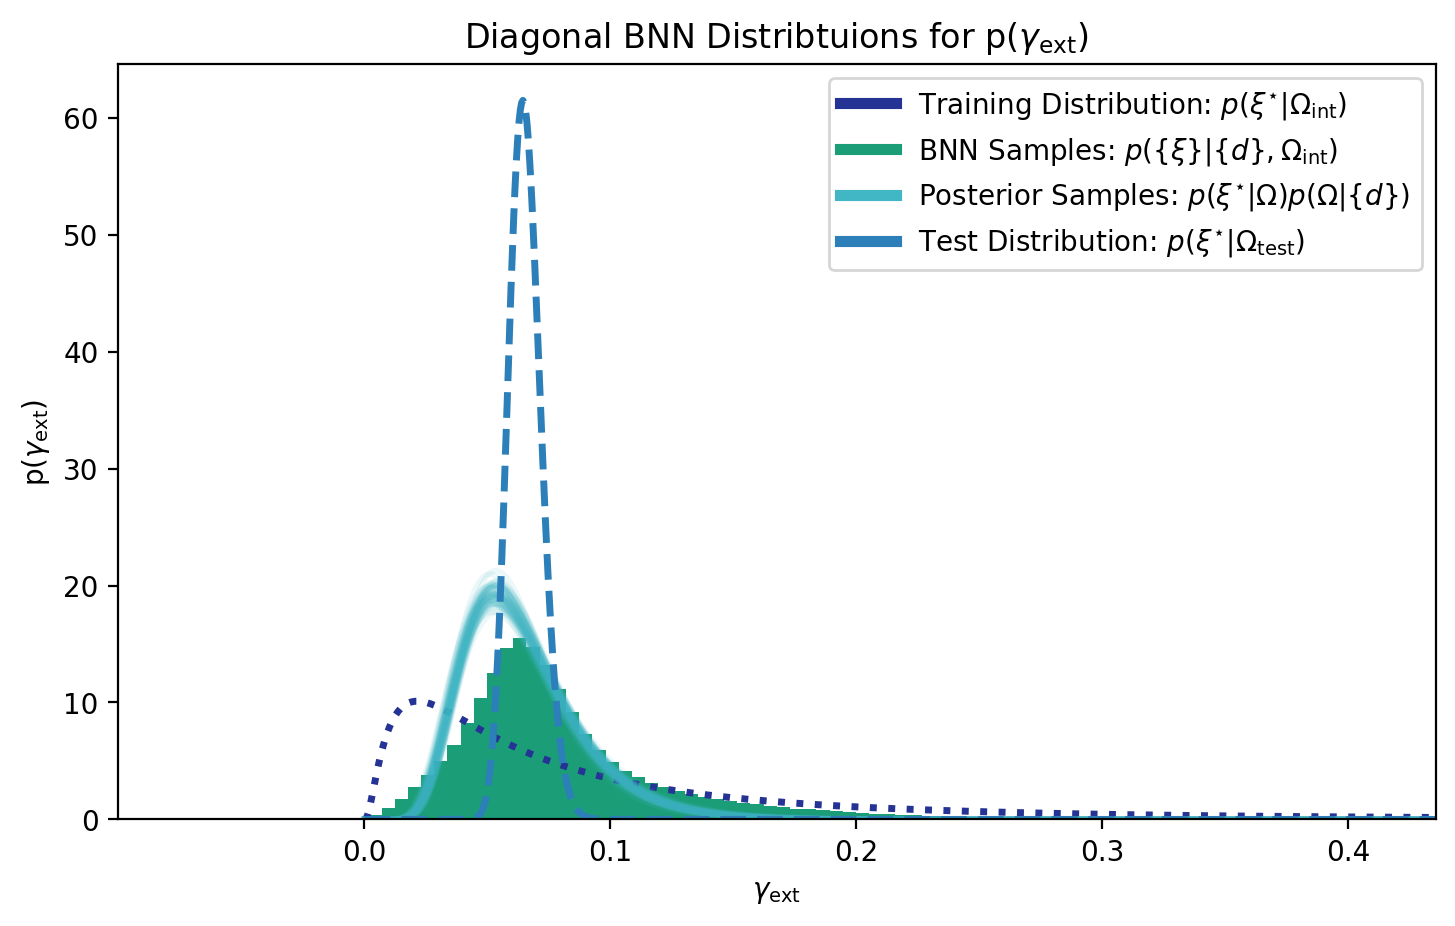

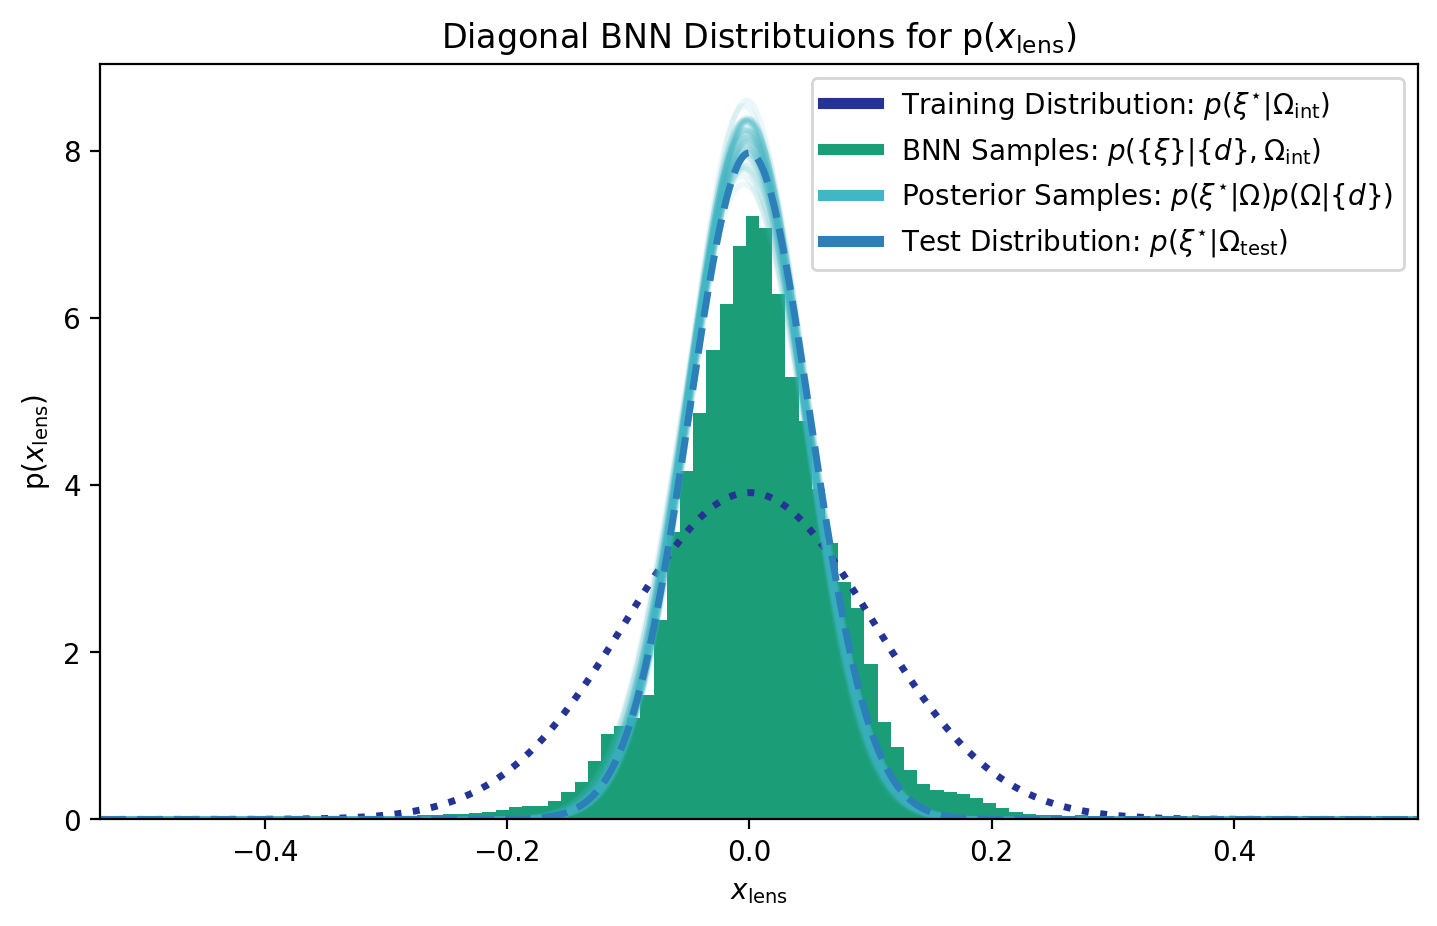

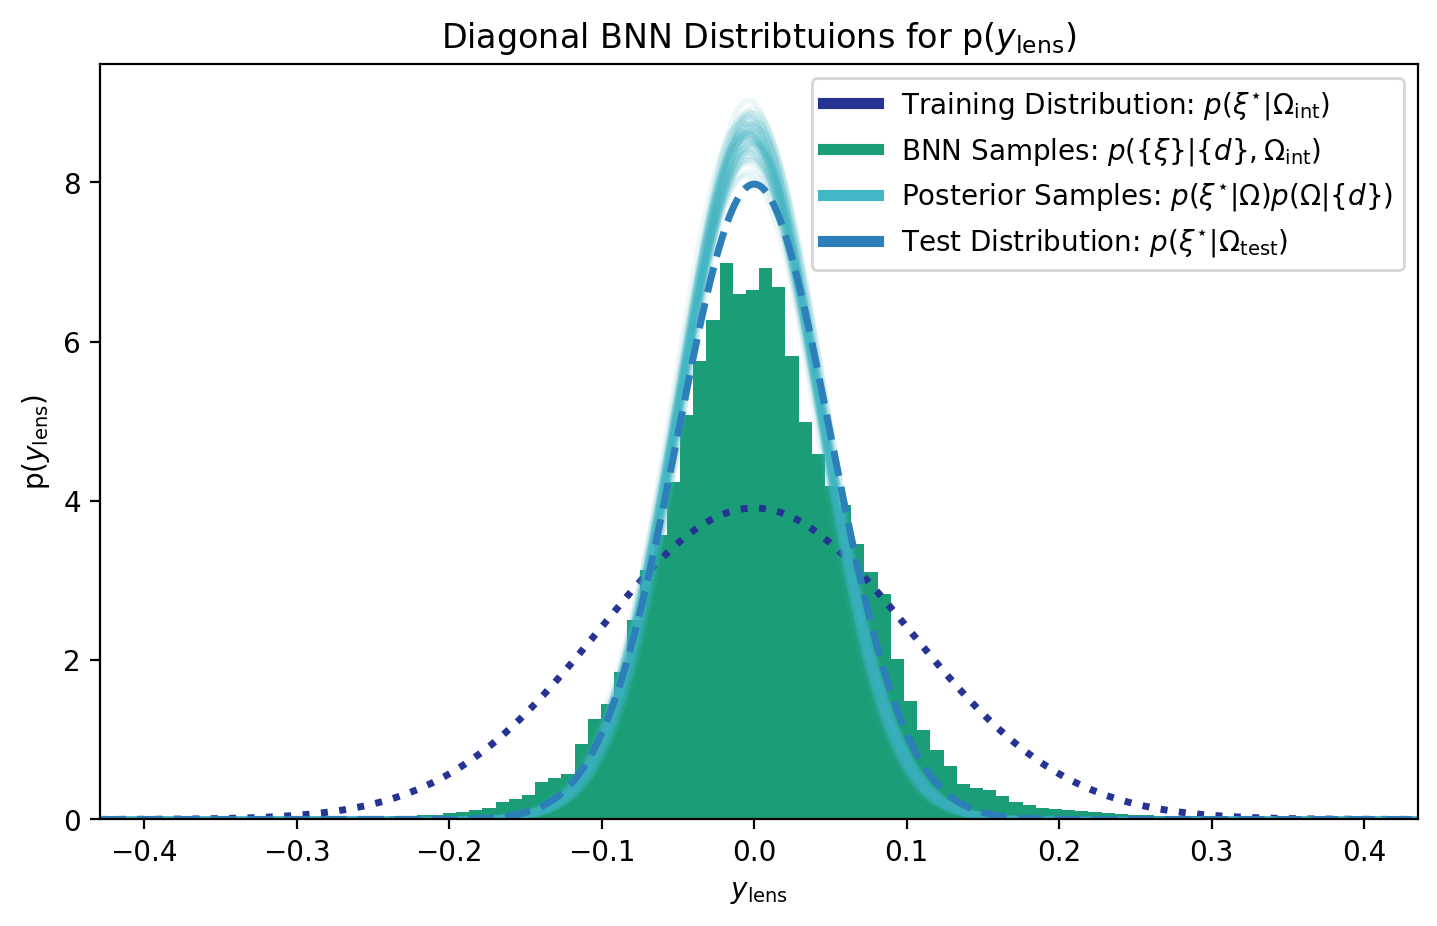

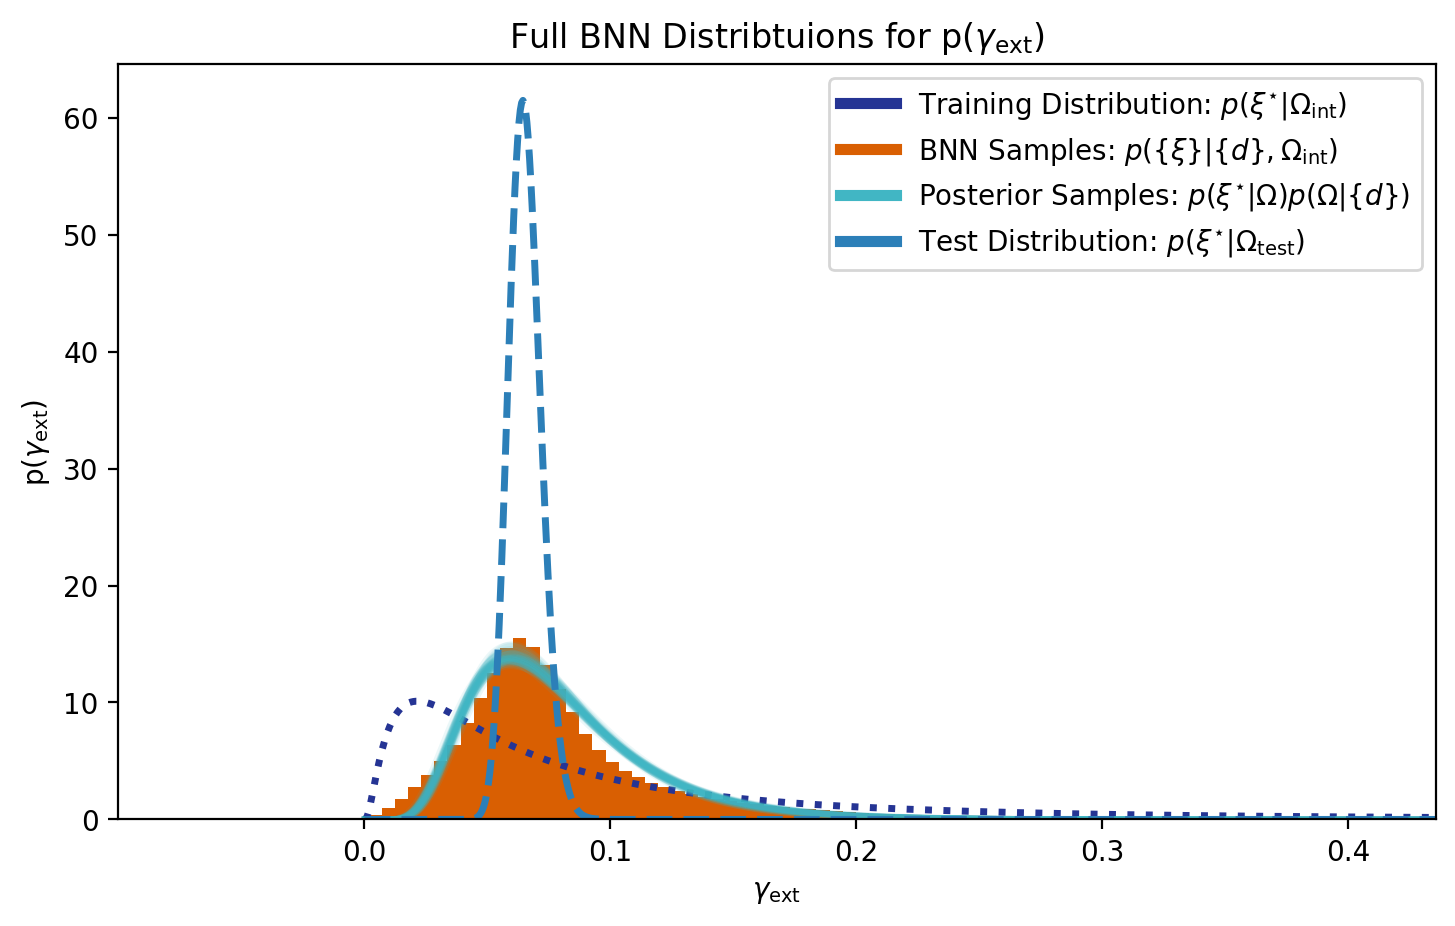

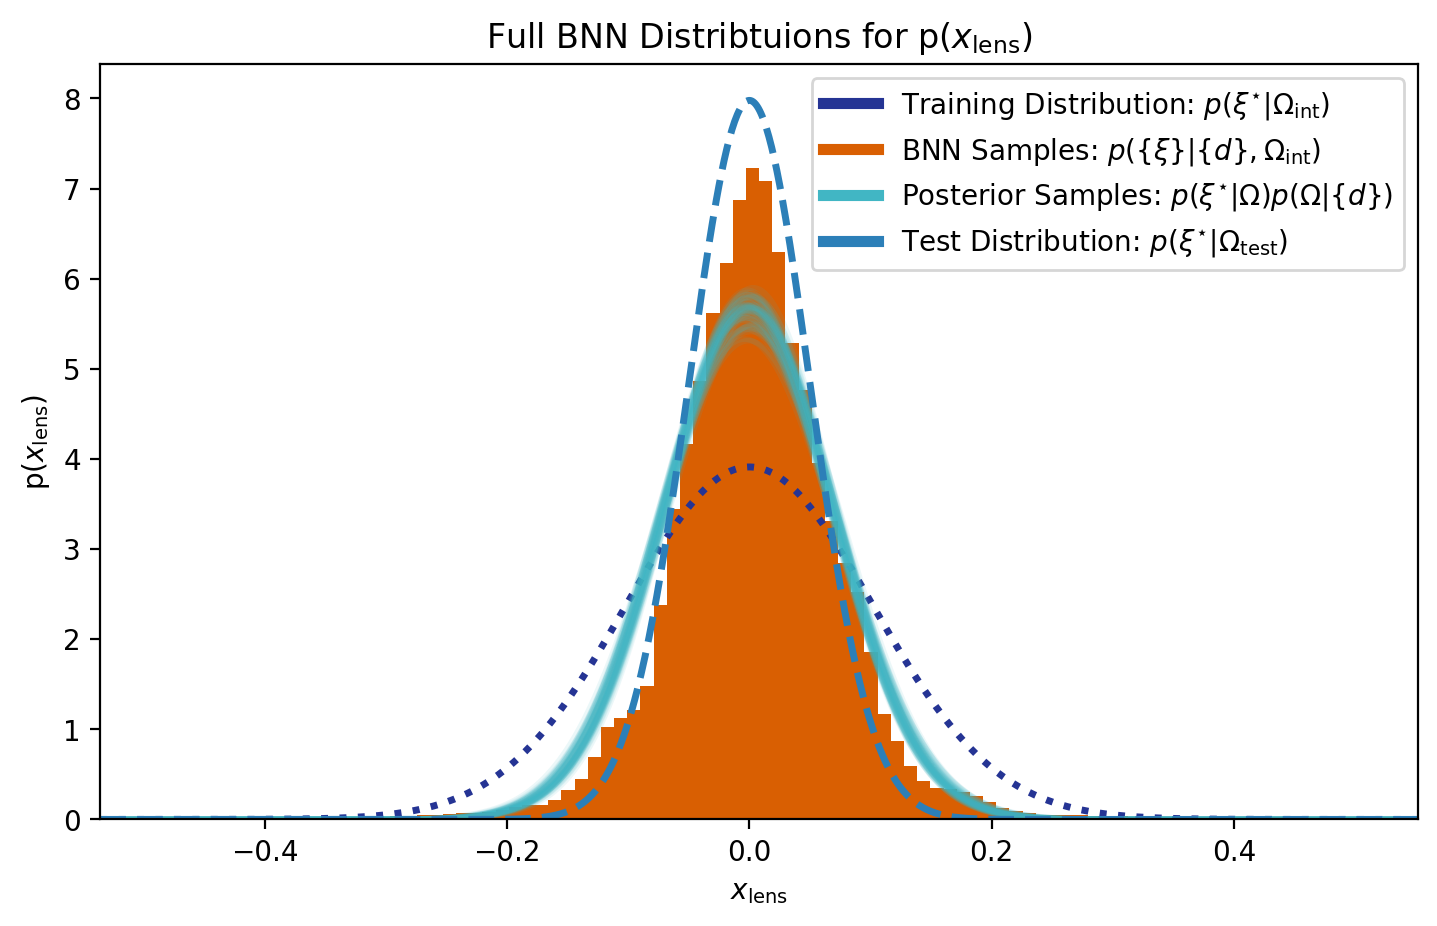

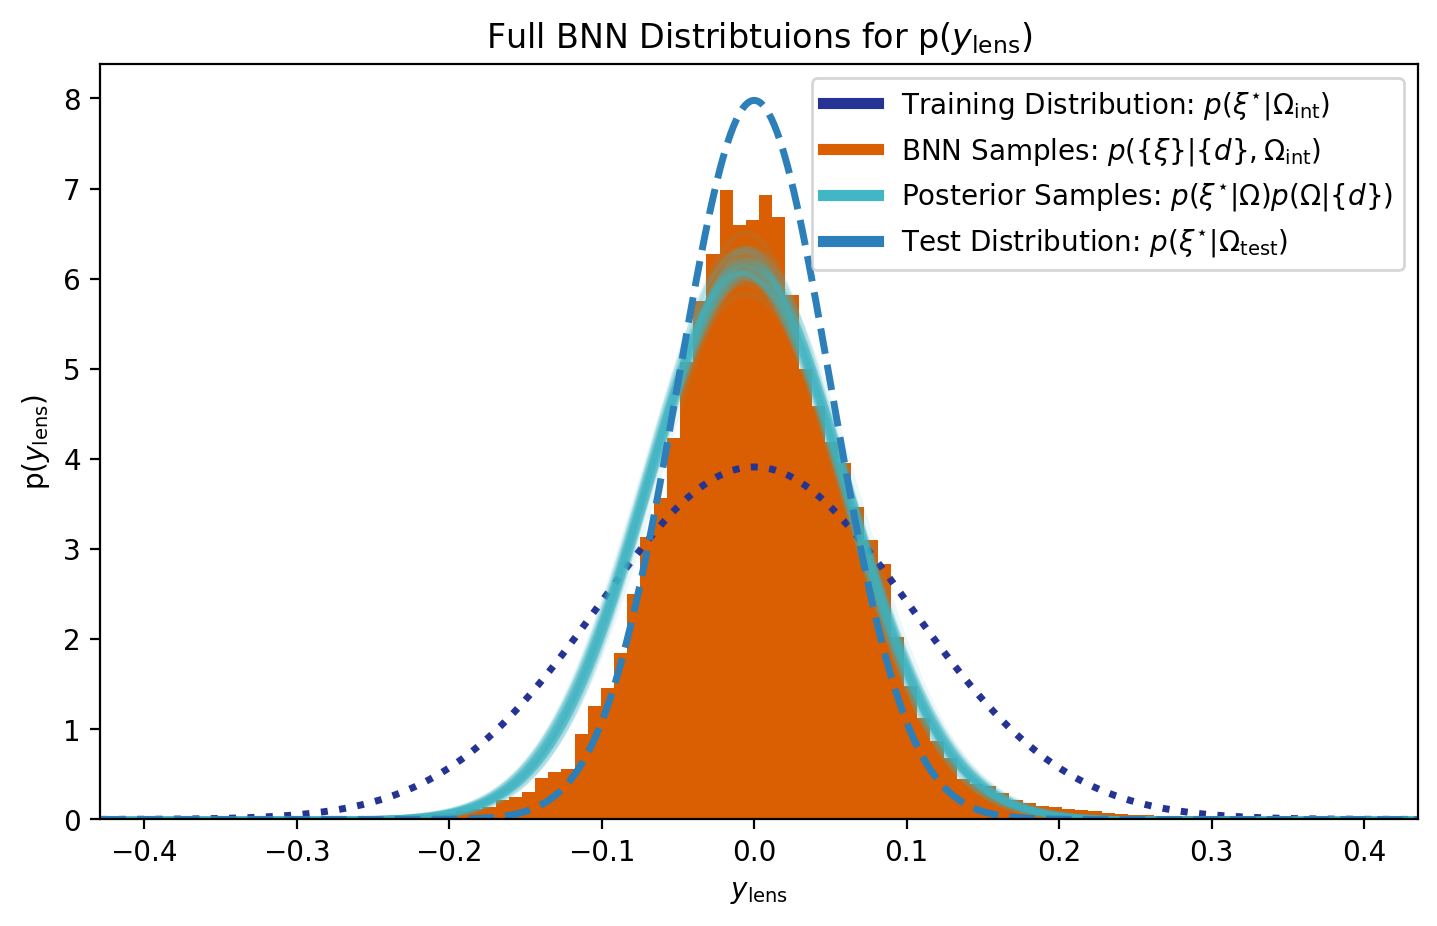

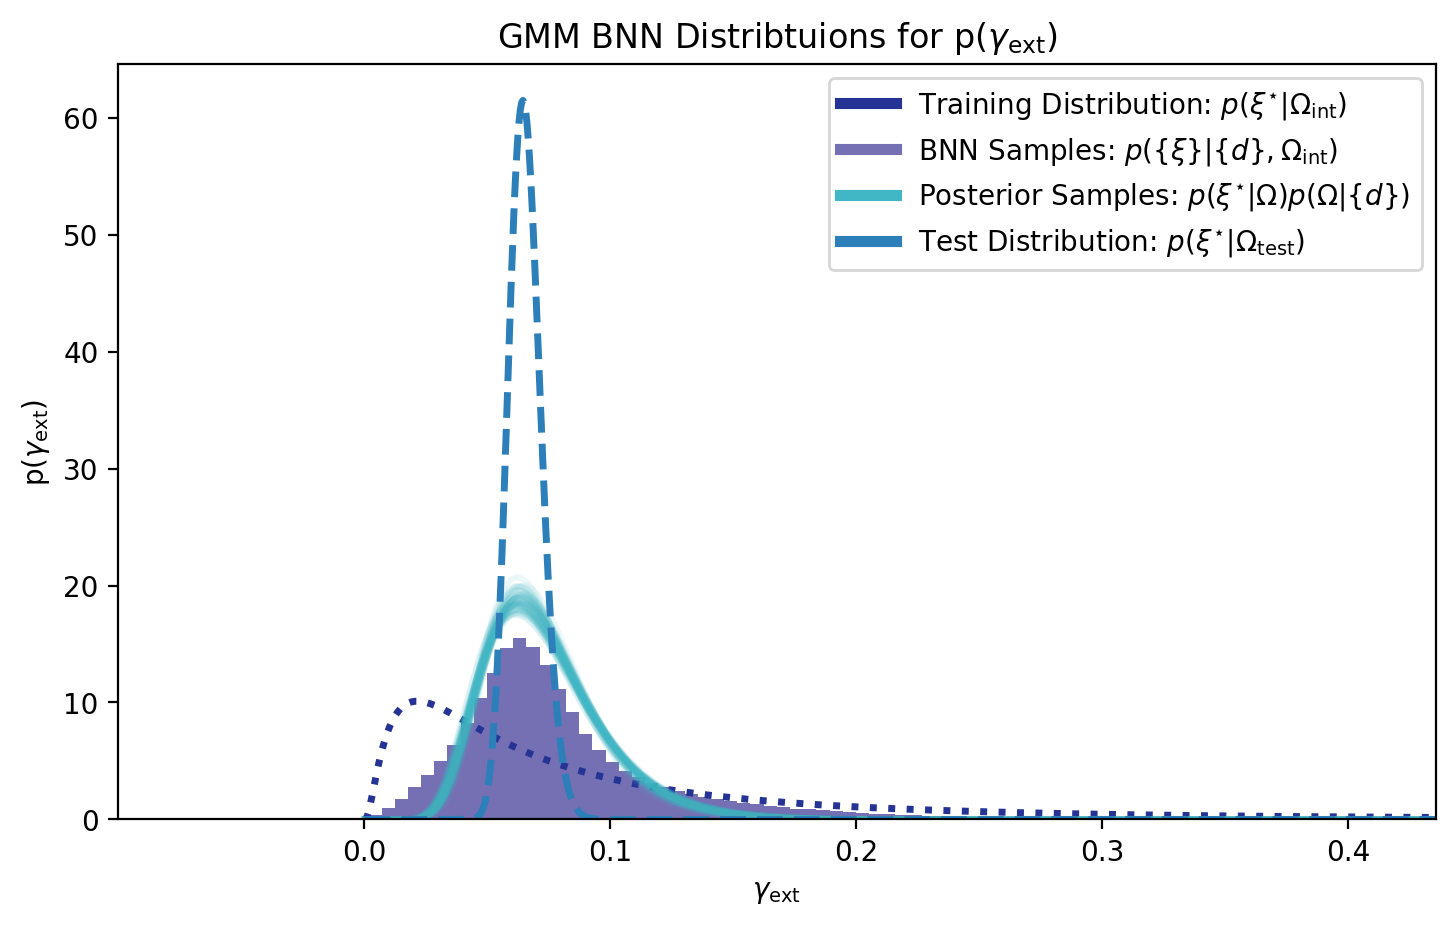

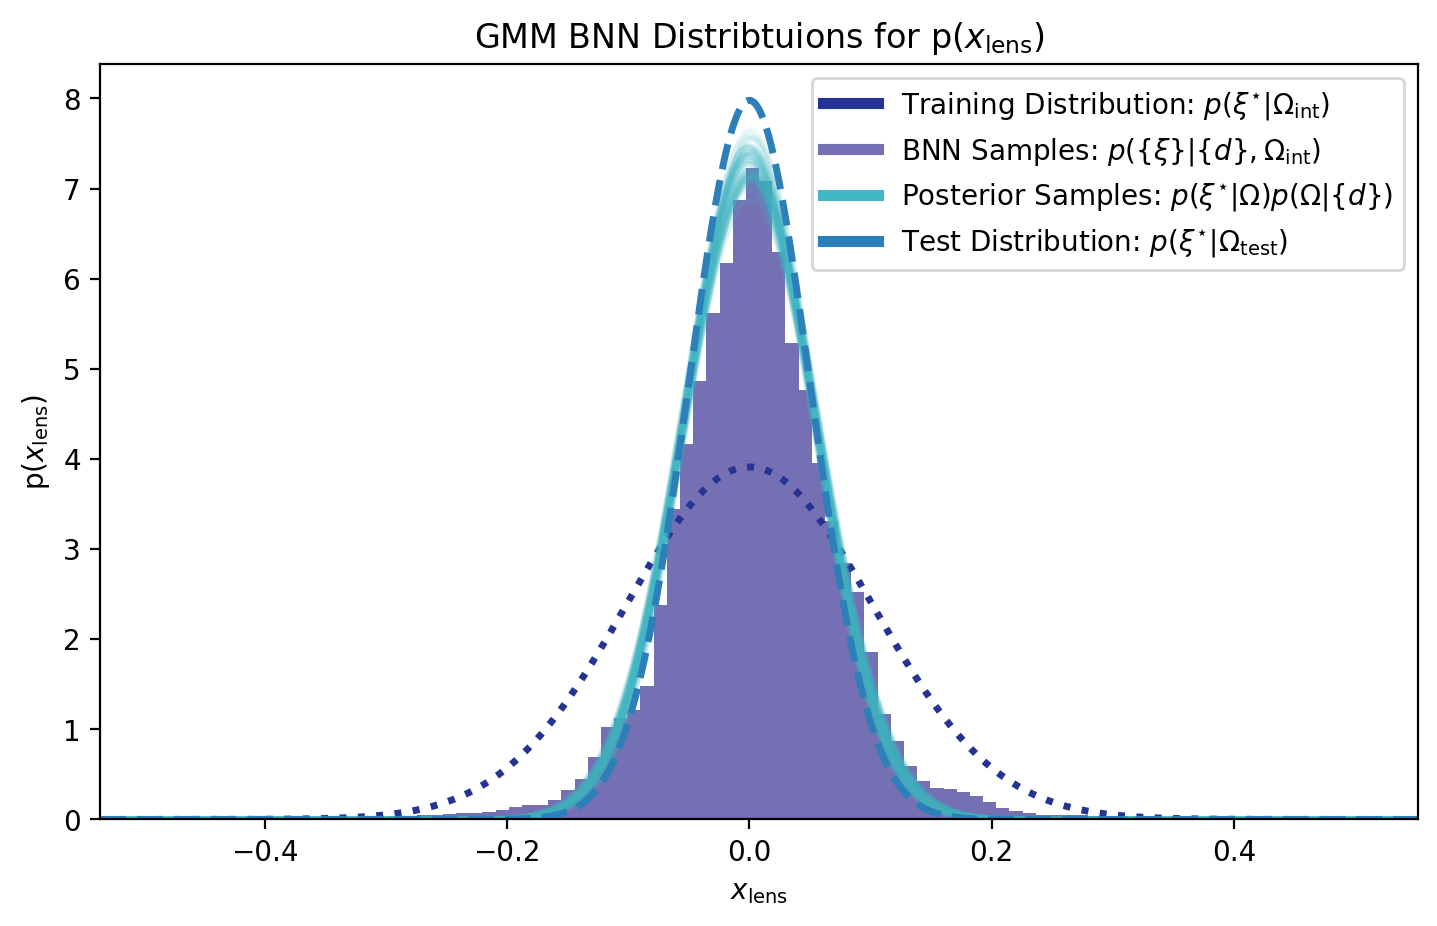

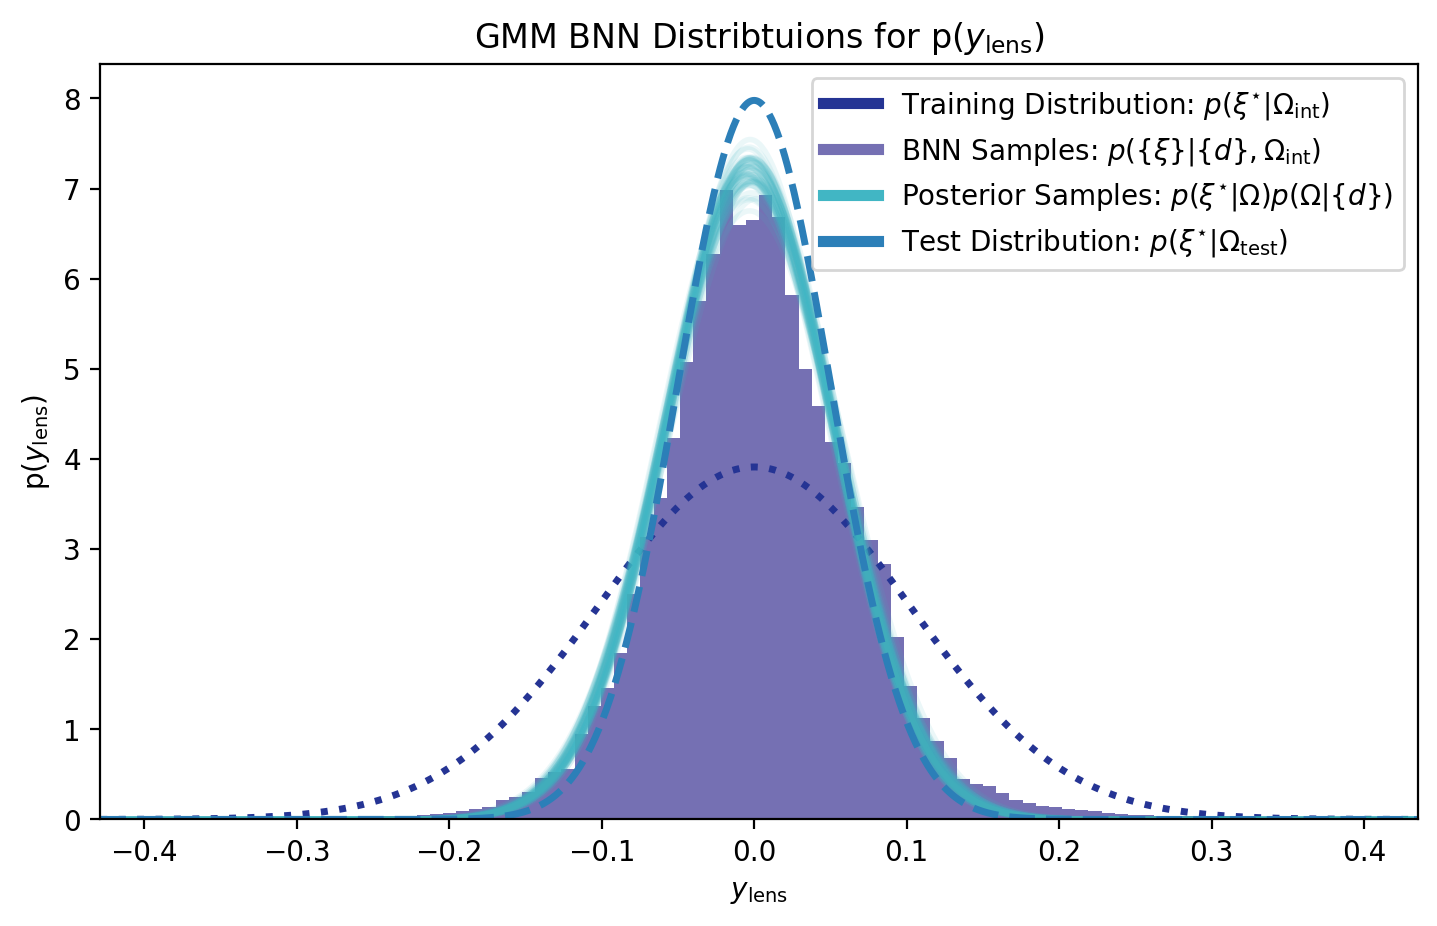

In [22]:
color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
bnn_name = 'Diagonal BNN'
save_fig_path = 'figures/sn_gamma_lens_1d_diag.pdf'
hier_infer_nn1.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)#,
                                 # plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#d95f02"
bnn_name = 'Full BNN'
save_fig_path = 'figures/sn_gamma_lens_1d_full.pdf'
hier_infer_nn2.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)#,
# #                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#7570b3" 
bnn_name = 'GMM BNN'
save_fig_path = 'figures/sn_gamma_lens_1d_gmm.pdf'
hier_infer_nn3.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)#,
#                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

In [23]:
mu_cov_samples = 30
corner_samples = 1024
nn1_corner_samples = []
nn2_corner_samples = []
nn3_corner_samples = []
for _ in range(mu_cov_samples):
    mu_nn1,cov_nn1 = hier_infer_nn1.sample_mu_cov(burnin)
    mu_nn2,cov_nn2 = hier_infer_nn2.sample_mu_cov(burnin)
    mu_nn3,cov_nn3 = hier_infer_nn3.sample_mu_cov(burnin)
    nn1_corner_samples.append(np.exp(np.random.multivariate_normal(mu_nn1,cov_nn1,size=corner_samples)))
    nn2_corner_samples.append(np.exp(np.random.multivariate_normal(mu_nn2,cov_nn2,size=corner_samples)))
    nn3_corner_samples.append(np.exp(np.random.multivariate_normal(mu_nn3,cov_nn3,size=corner_samples)))

nn1_corner_samples = np.array(nn1_corner_samples)
nn1_corner_samples=nn1_corner_samples.reshape((-1,nn1_corner_samples.shape[-1]))
nn2_corner_samples = np.array(nn2_corner_samples)
nn2_corner_samples=nn2_corner_samples.reshape((-1,nn2_corner_samples.shape[-1]))
nn3_corner_samples = np.array(nn3_corner_samples)
nn3_corner_samples=nn3_corner_samples.reshape((-1,nn3_corner_samples.shape[-1]))

# Get the samples for the emprical distribution metadata
emp_metadata = pd.read_csv(root_path+'datasets/empirical/metadata.csv')
lens_params = cfg['dataset_params']['lens_params']
emp_samps = emp_metadata[lens_params].to_numpy()
e1=emp_samps[:,4]
e2=emp_samps[:,5]
_,q = ellipticity2phi_q(e1,e2)
emp_samps_cov = np.array([emp_samps[:,-1],q,emp_samps[:,-2]])

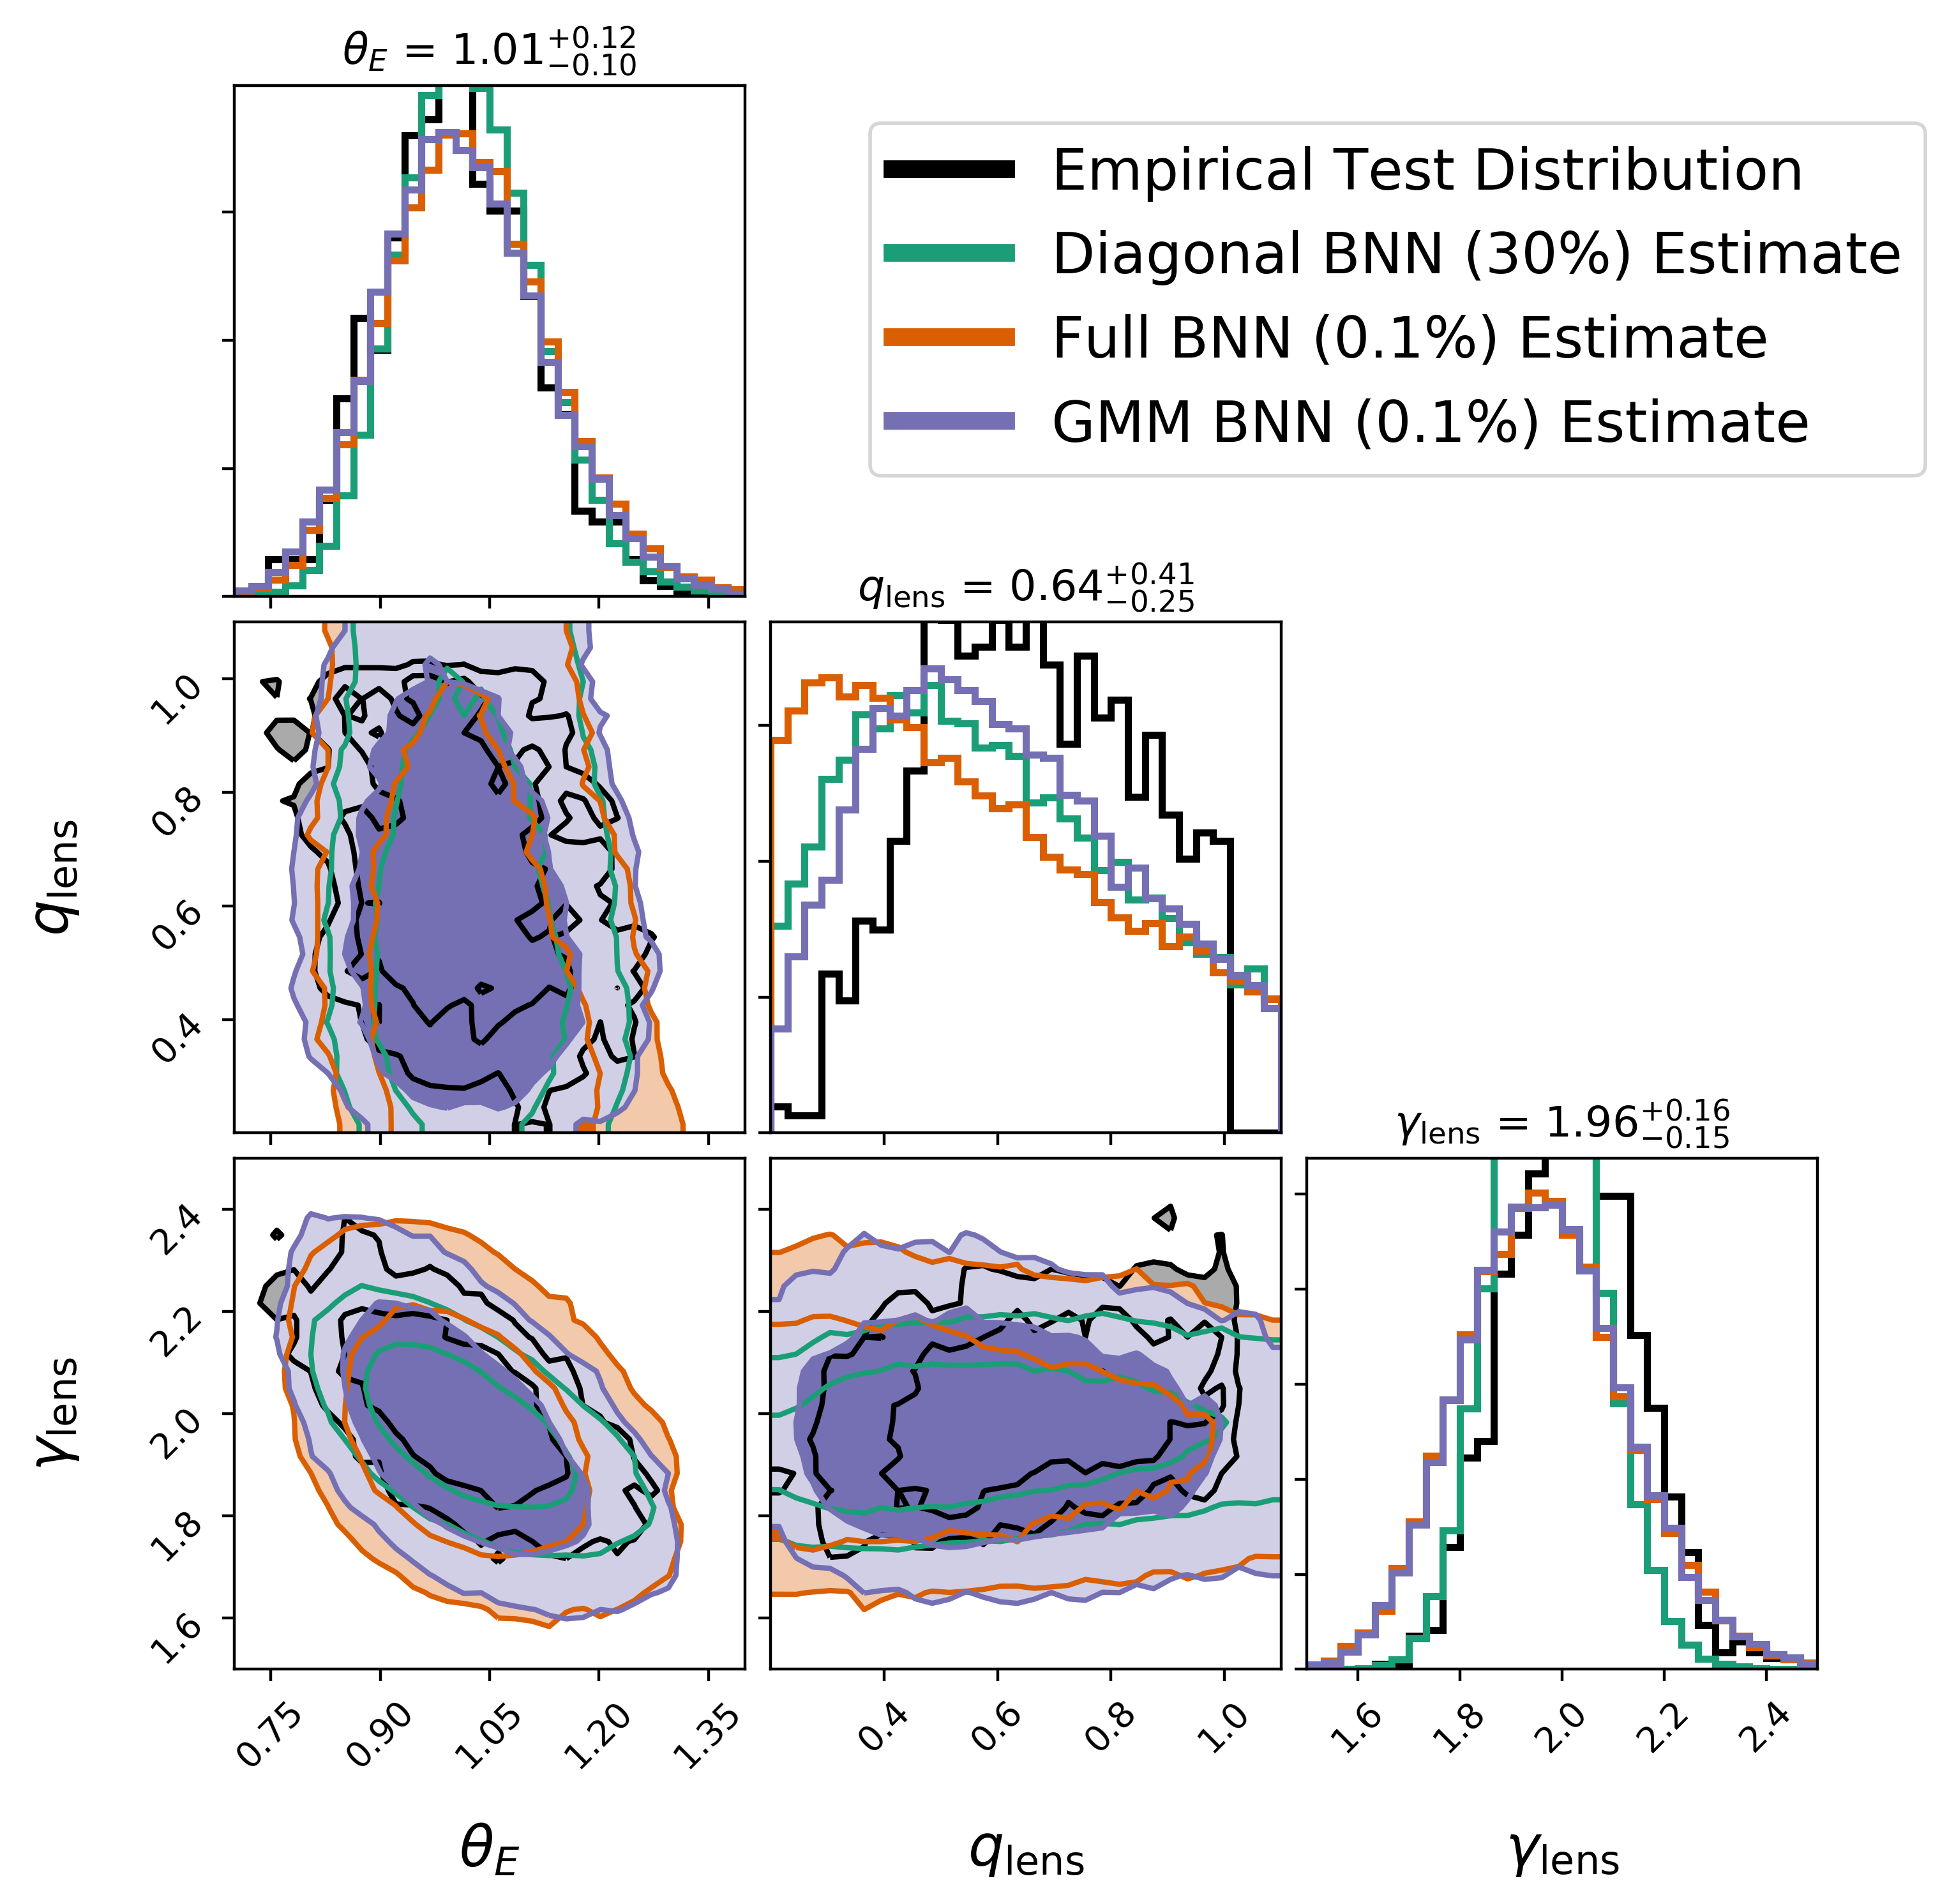

In [24]:
figure= None
color_map = ['000000','#1b9e77','#d95f02','#7570b3']
plot_limits = [[0.7,1.4],[0.2,1.1],[1.5,2.5]]
# hist_limit = [20,10,10,10,10,15,20]
smooth = 0.6
# fontsize = 16
final_params_print_names_cov = [r'$\theta_E$',r'$q_\mathrm{lens}$',r'$\gamma_\mathrm{lens}$']
hist_kwargs = {'density':True,'color':color_map[0],'lw':2}
figure = corner.corner(emp_samps_cov.T,labels=final_params_print_names_cov,bins=30,show_titles=True, 
                       plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),color=color_map[0],
                       levels=[0.68,0.95],fill_contours=True,smooth=smooth,
                       fig=figure,hist_kwargs=hist_kwargs,dpi=400,range=plot_limits)
hist_kwargs['color']=color_map[1]
figure = corner.corner(nn1_corner_samples,labels=final_params_print_names_cov,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[1],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,smooth=smooth,hist_kwargs=hist_kwargs,range=plot_limits)
hist_kwargs['color']=color_map[2]
figure = corner.corner(nn2_corner_samples,labels=final_params_print_names_cov,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[2],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,smooth=smooth,hist_kwargs=hist_kwargs,range=plot_limits)
hist_kwargs['color']=color_map[3]
figure = corner.corner(nn3_corner_samples,labels=final_params_print_names_cov,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[3],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,smooth=smooth,hist_kwargs=hist_kwargs,range=plot_limits)
handles = [Line2D([0], [0], color=color_map[0], lw=5),
           Line2D([0], [0], color=color_map[1], lw=5),
           Line2D([0], [0], color=color_map[2], lw=5),
           Line2D([0], [0], color=color_map[3], lw=5)]
figure.legend(handles,[r'Empirical Test Distribution', r'Diagonal BNN (30%) Estimate', r'Full BNN (0.1%) Estimate',
                       r'GMM BNN (0.1%) Estimate'],
              loc=(0.45,0.75),fontsize=fontsize)
plt.show()

## Compare performance of GMM model, varying dropout rate, on centered narrow

In [62]:
# Diagonal model 30% dropout chains on shifted test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/cent_narrow_cfg_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/cent_narrow.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_cn'
n_walkers = 50
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\log (\gamma_\mathrm{lens})}$',r'$\sigma_{\log (\gamma_\mathrm{lens})}$',
                         r'$\mu_{\log (\theta_E)}$',r'$\sigma_{\log (\theta_E)}$']

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3_slr = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr_samps/'
hier_infer_nn3_slr.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr.h5'
hier_infer_nn3_slr.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

config_path = root_path + 'configs/nn3_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3_lr = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_lr = root_path + 'hierarchical_results/cn_nn3_lr_samps/'
hier_infer_nn3_lr.gen_samples(num_samples,save_path_samples_nn3_lr)
save_path_chains_nn3_lr = root_path + 'hierarchical_results/cn_nn3_lr.h5'
hier_infer_nn3_lr.initialize_sampler(n_walkers,save_path_chains_nn3_lr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3 = root_path + 'hierarchical_results/cn_nn3_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3)
save_path_chains_nn3 = root_path + 'hierarchical_results/cn_nn3.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3)

Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr.h5
Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_lr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_lr_samps/
Loading samples from /Users/sebwagner/D

In [63]:
burnin = 8000
# hier_infer_nn3_slr.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3_lr.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_lr.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

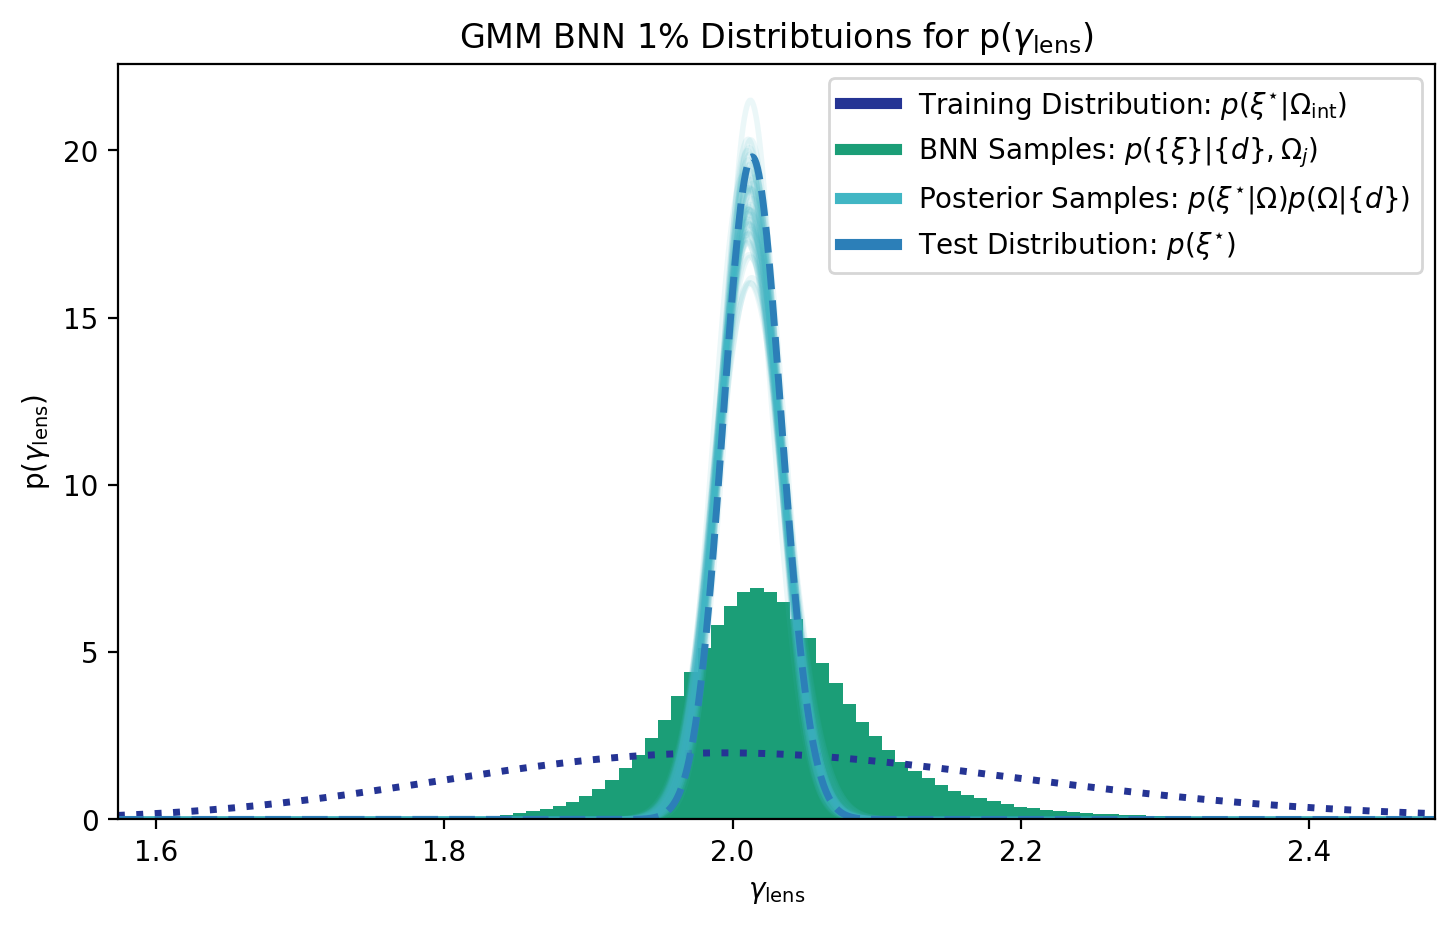

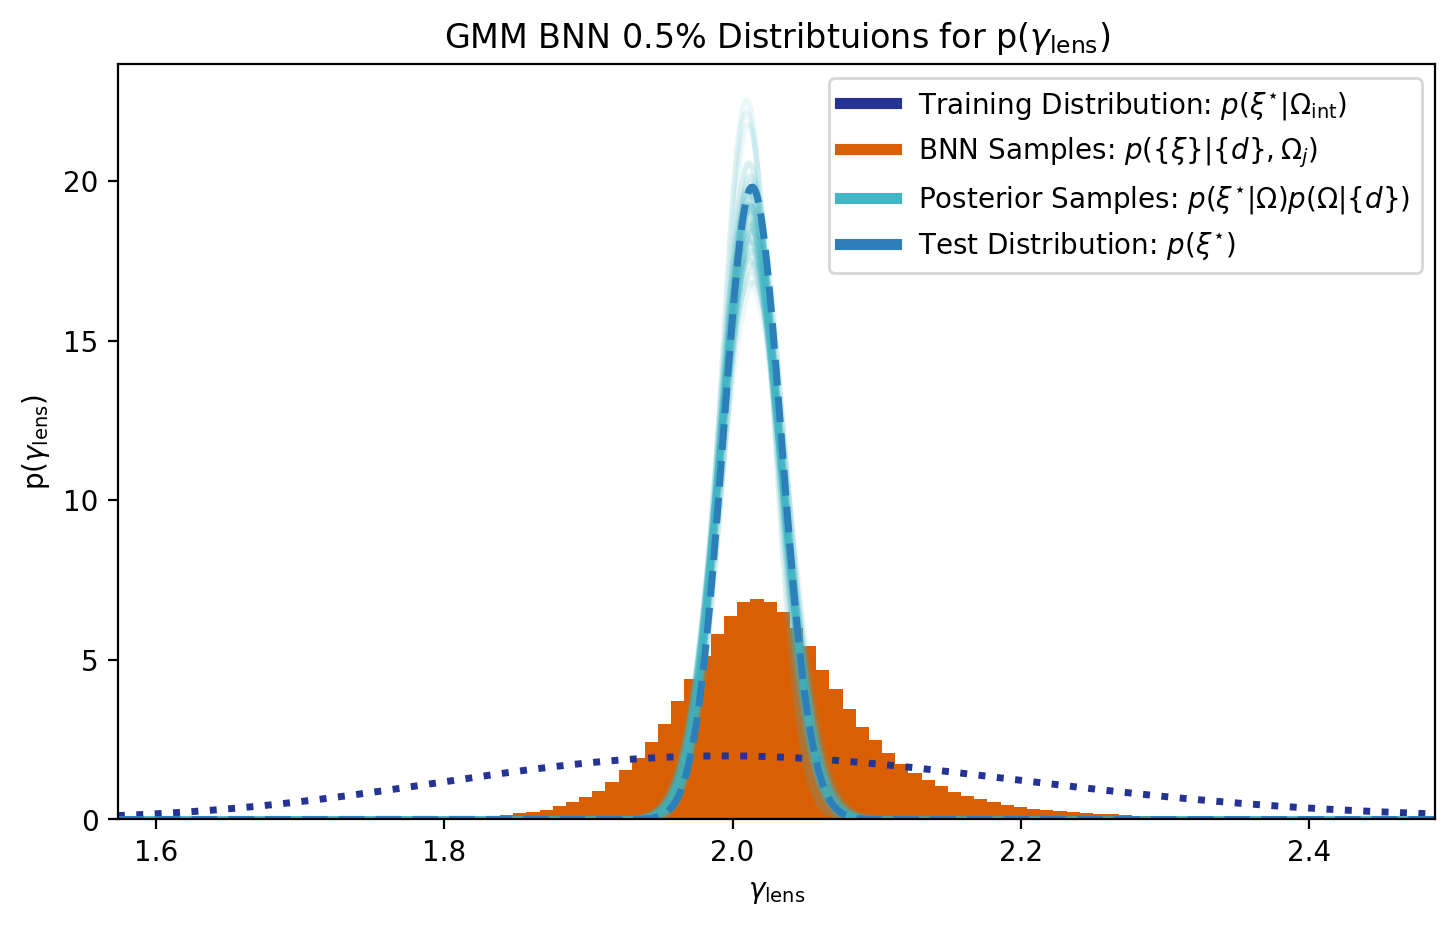

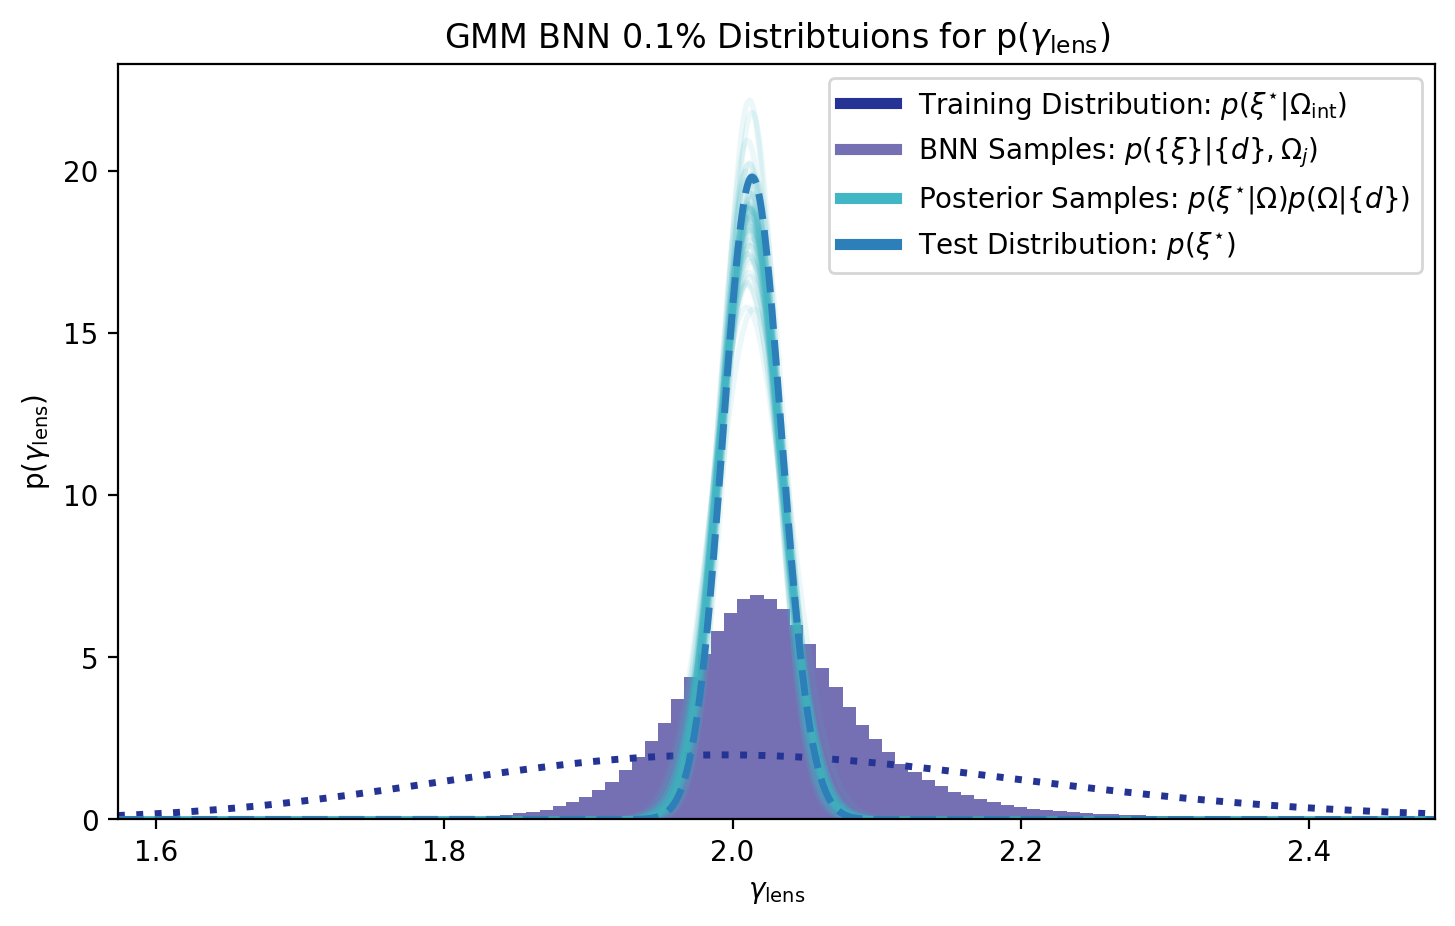

In [64]:
color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
bnn_name = 'GMM BNN 1%'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm_10.pdf'
hier_infer_nn3.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#d95f02"
bnn_name = 'GMM BNN 0.5%'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm_05.pdf'
hier_infer_nn3_lr.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#7570b3" 
bnn_name = 'GMM BNN 0.1%'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm.pdf'
hier_infer_nn3_slr.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

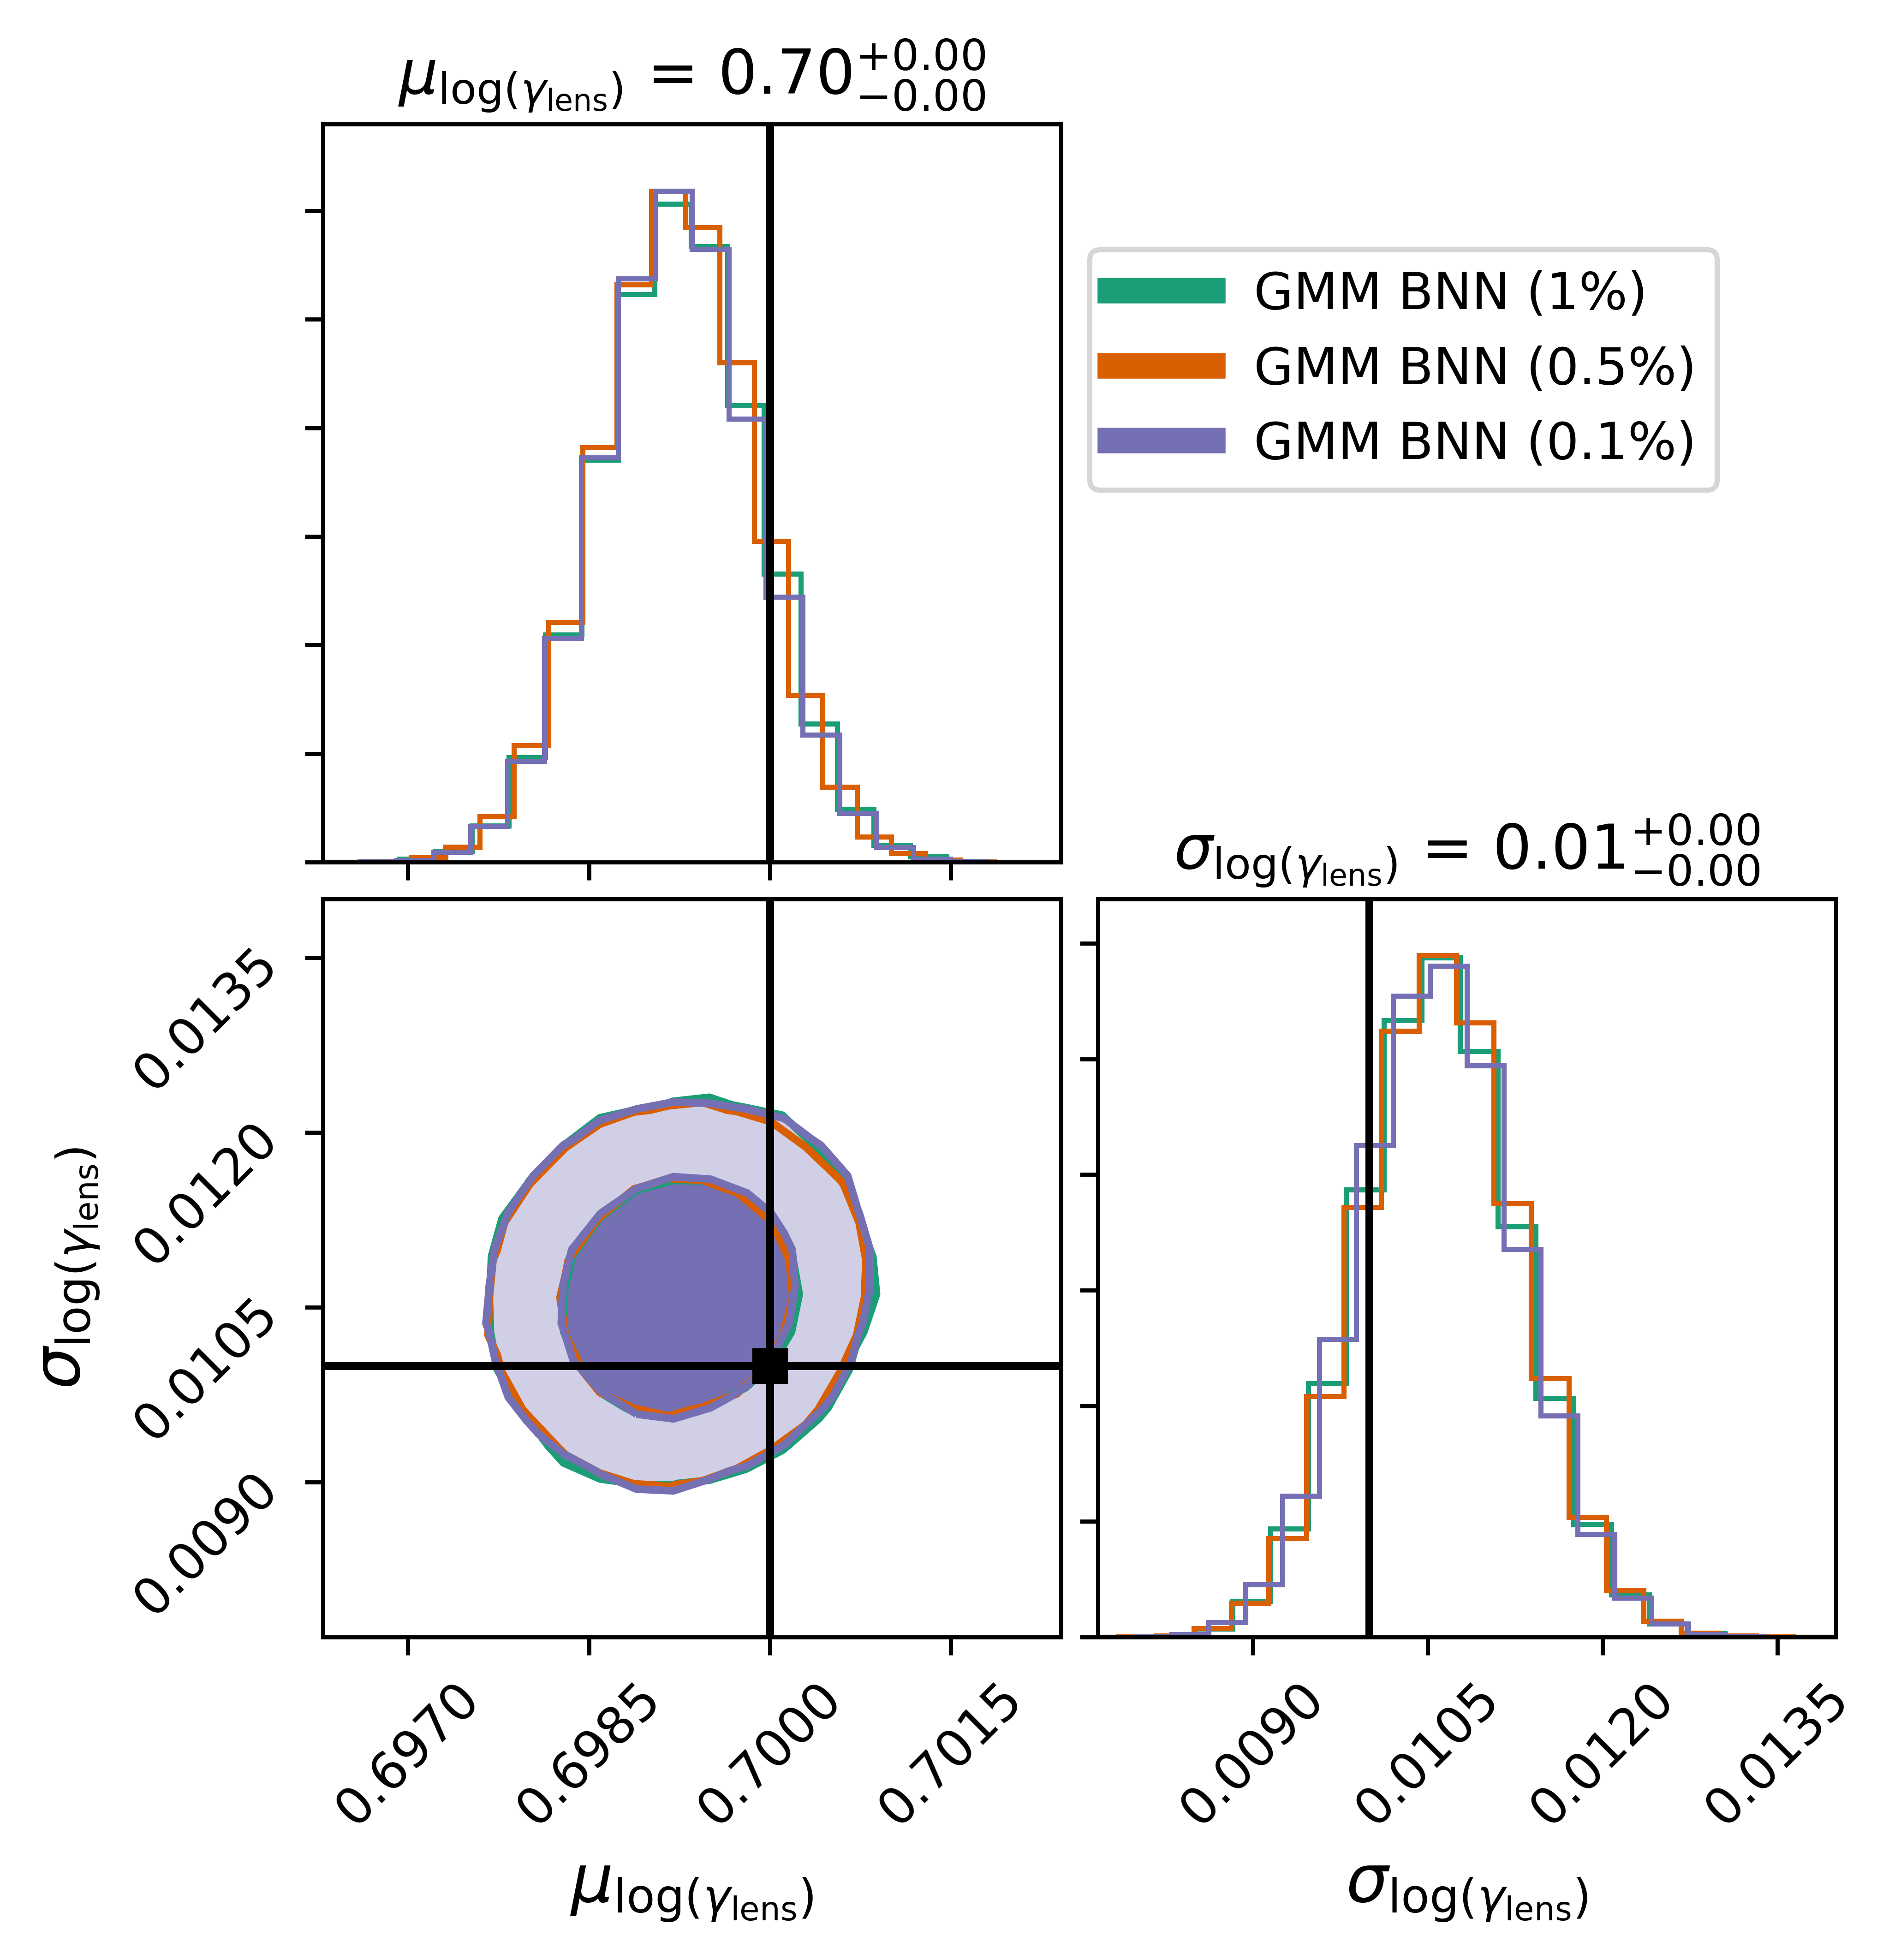

In [48]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
plot_range = None#[[0.77,0.802],[0.009,0.02]]
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn3_lr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN (1%)', r'GMM BNN (0.5%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/cn_gamma_lens_2d_hyps_r.pdf')
plt.show(figure)

## Compare performance of GMM model, varying number of lenses, on centered narrow

In [49]:
# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr_samps/'
hier_infer_nn3_slr.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr.h5'
hier_infer_nn3_slr.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

# Now 256 lenses
hier_infer_nn3_slr_256 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
num_lenses = 256
hier_infer_nn3_slr_256.gen_samples(num_samples,save_path_samples_nn3_slr,num_lenses)
save_path_chains_nn3_slr_256 = root_path + 'hierarchical_results/cn_nn3_slr_256.h5'
hier_infer_nn3_slr_256.initialize_sampler(n_walkers,save_path_chains_nn3_slr_256)

# GMM Model 0.1% Dropout
hier_infer_nn3_slr_64 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
num_lenses = 64
hier_infer_nn3_slr_64.gen_samples(num_samples,save_path_samples_nn3_slr,num_lenses)
save_path_chains_nn3_slr_64 = root_path + 'hierarchical_results/cn_nn3_slr_64.h5'
hier_infer_nn3_slr_64.initialize_sampler(n_walkers,save_path_chains_nn3_slr_64)

Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loading samp

In [53]:
burnin = 8000
# hier_infer_nn3_slr.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3_slr_256.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr_256.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3_slr_64.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr_64.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

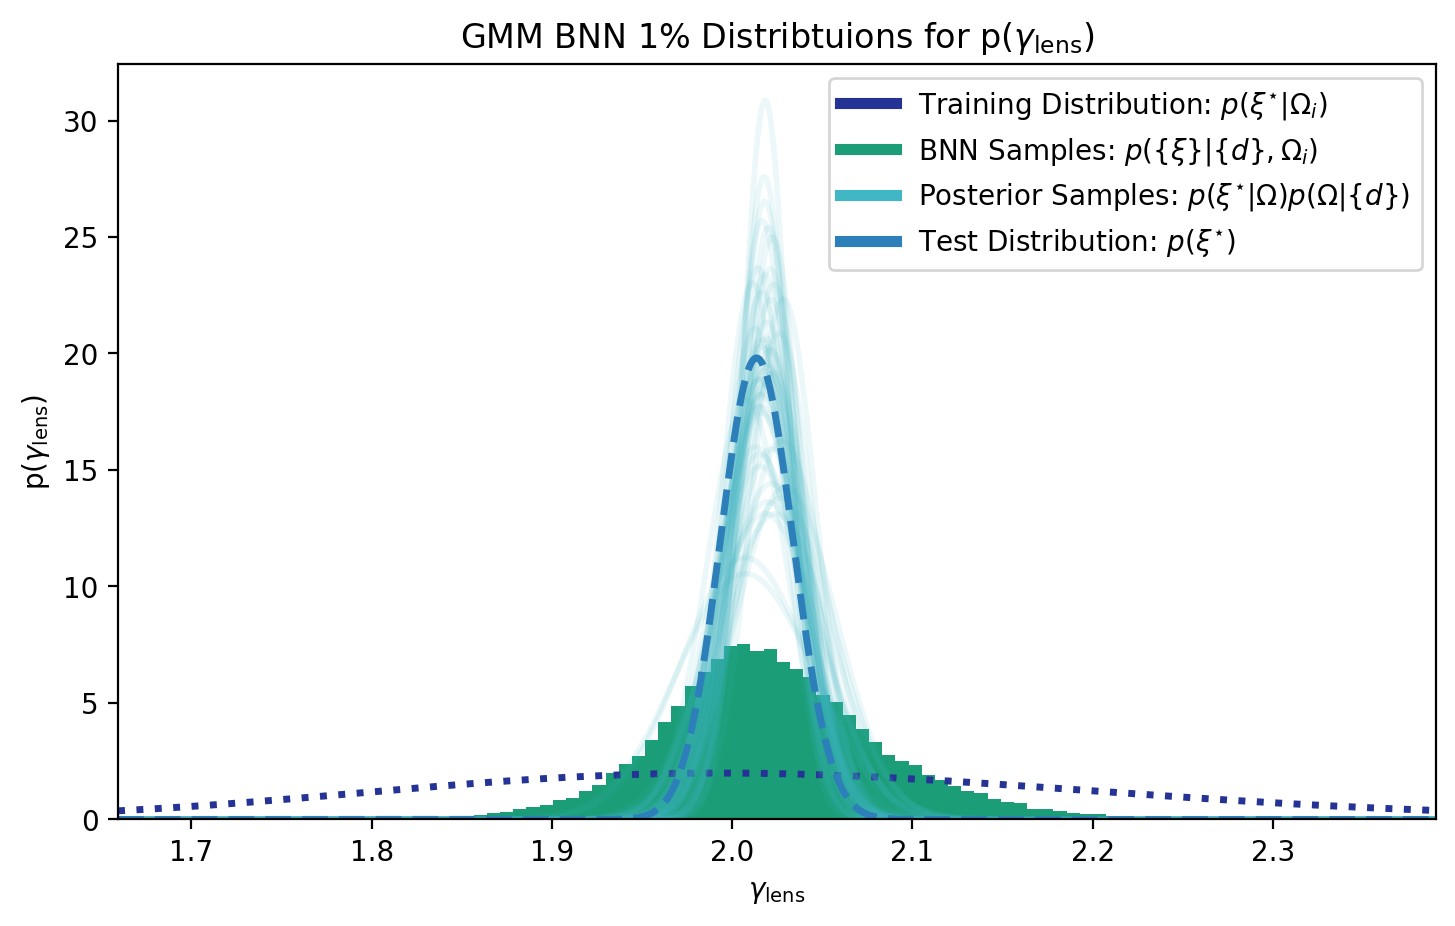

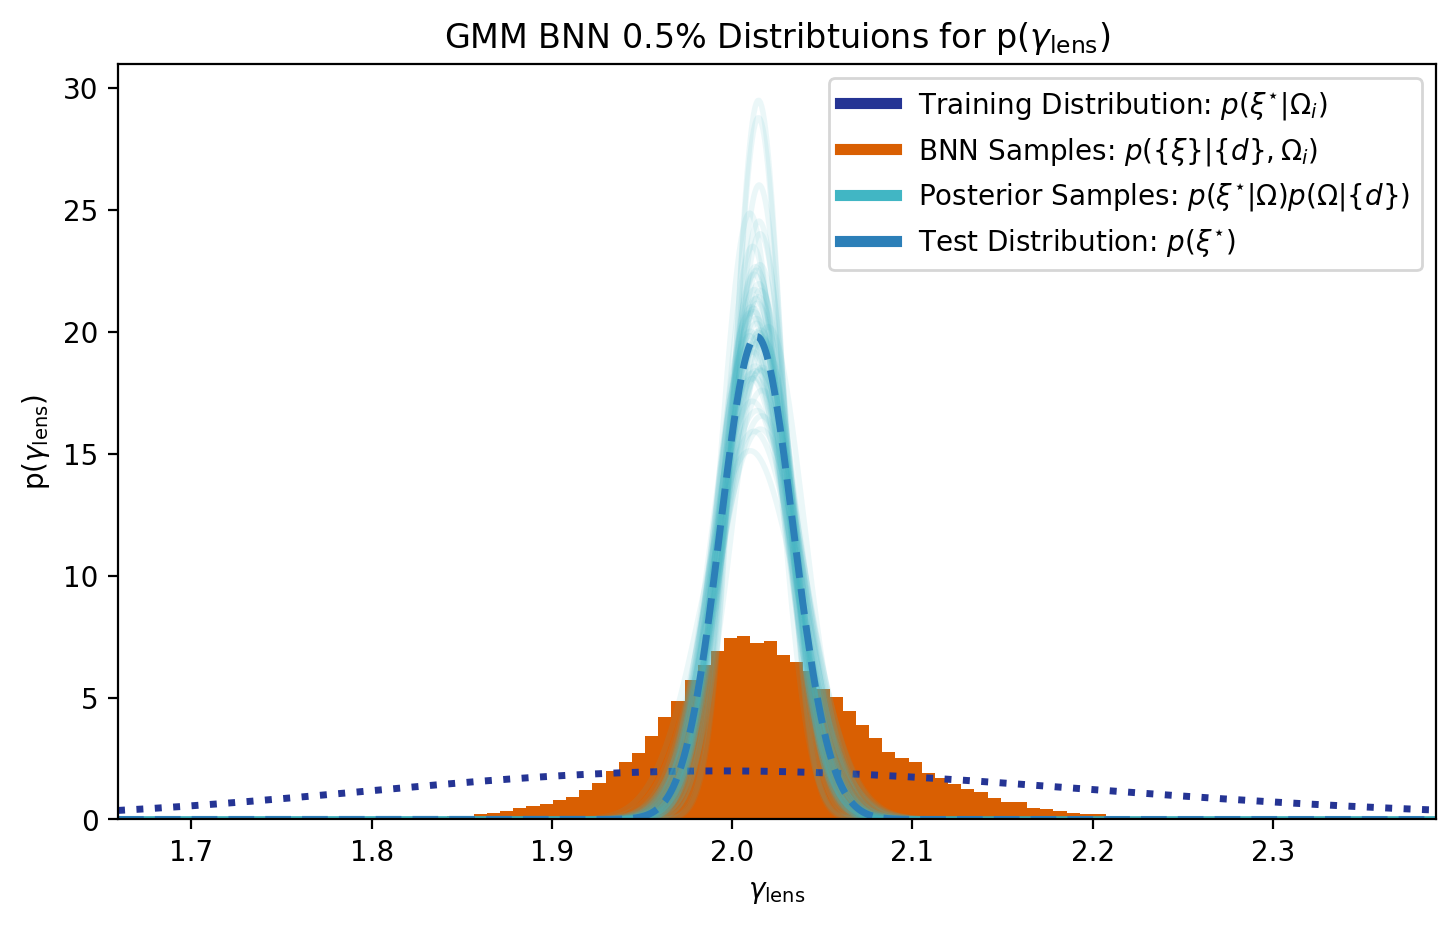

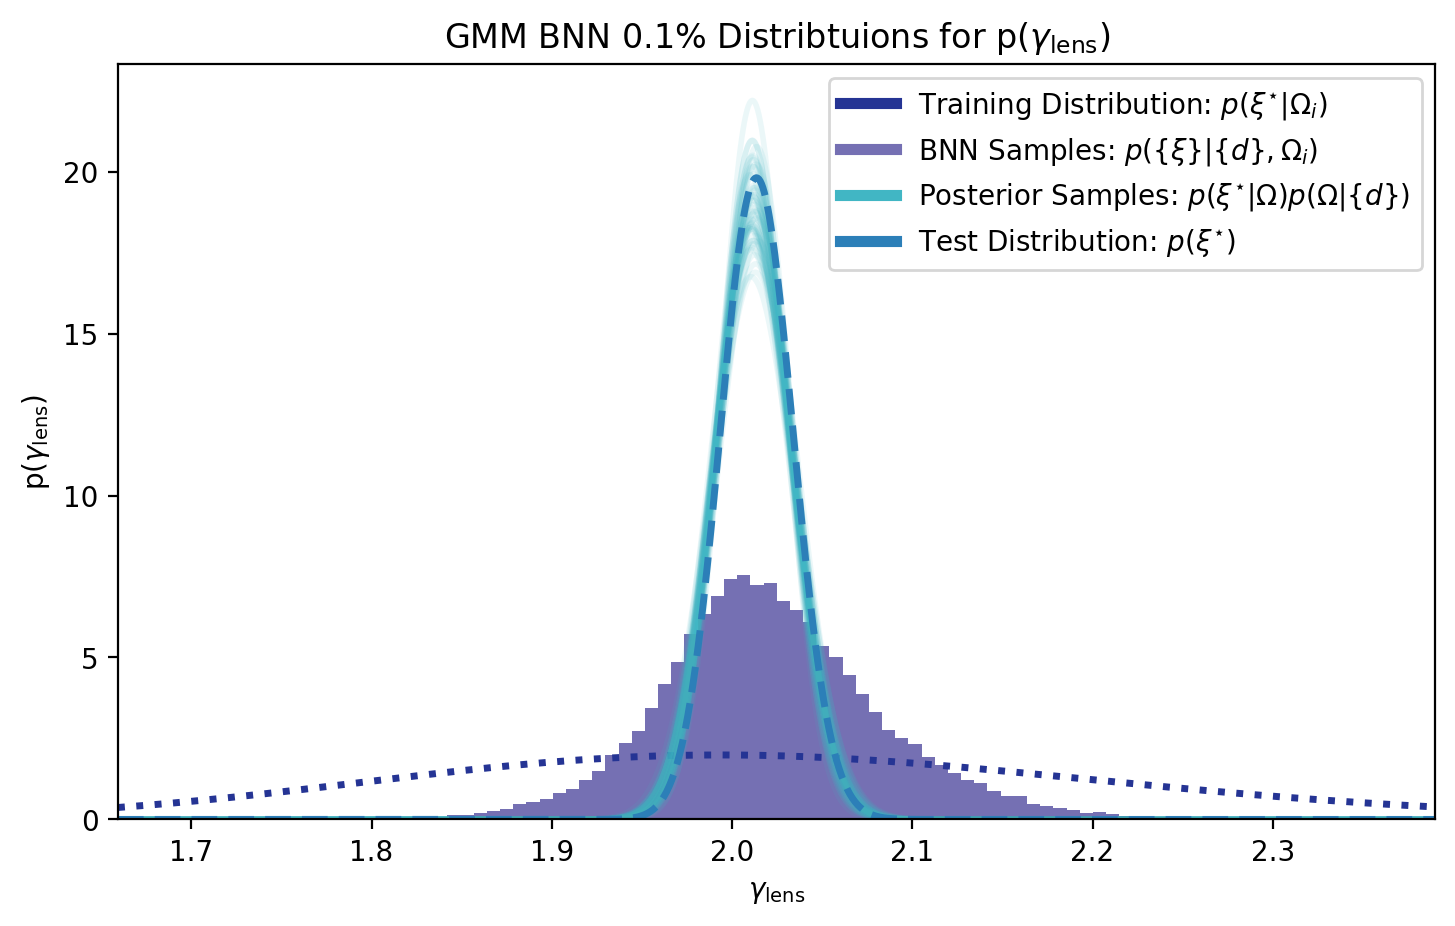

In [56]:
color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
bnn_name = 'GMM BNN 1%'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm_64.pdf'
hier_infer_nn3_slr_64.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#d95f02"
bnn_name = 'GMM BNN 0.5%'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm_256.pdf'
hier_infer_nn3_slr_256.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

color_map[1] = "#7570b3" 
bnn_name = 'GMM BNN 0.1%'
save_fig_path = 'figures/cn_gamma_lens_1d_gmm.pdf'
hier_infer_nn3_slr.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
                                  plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

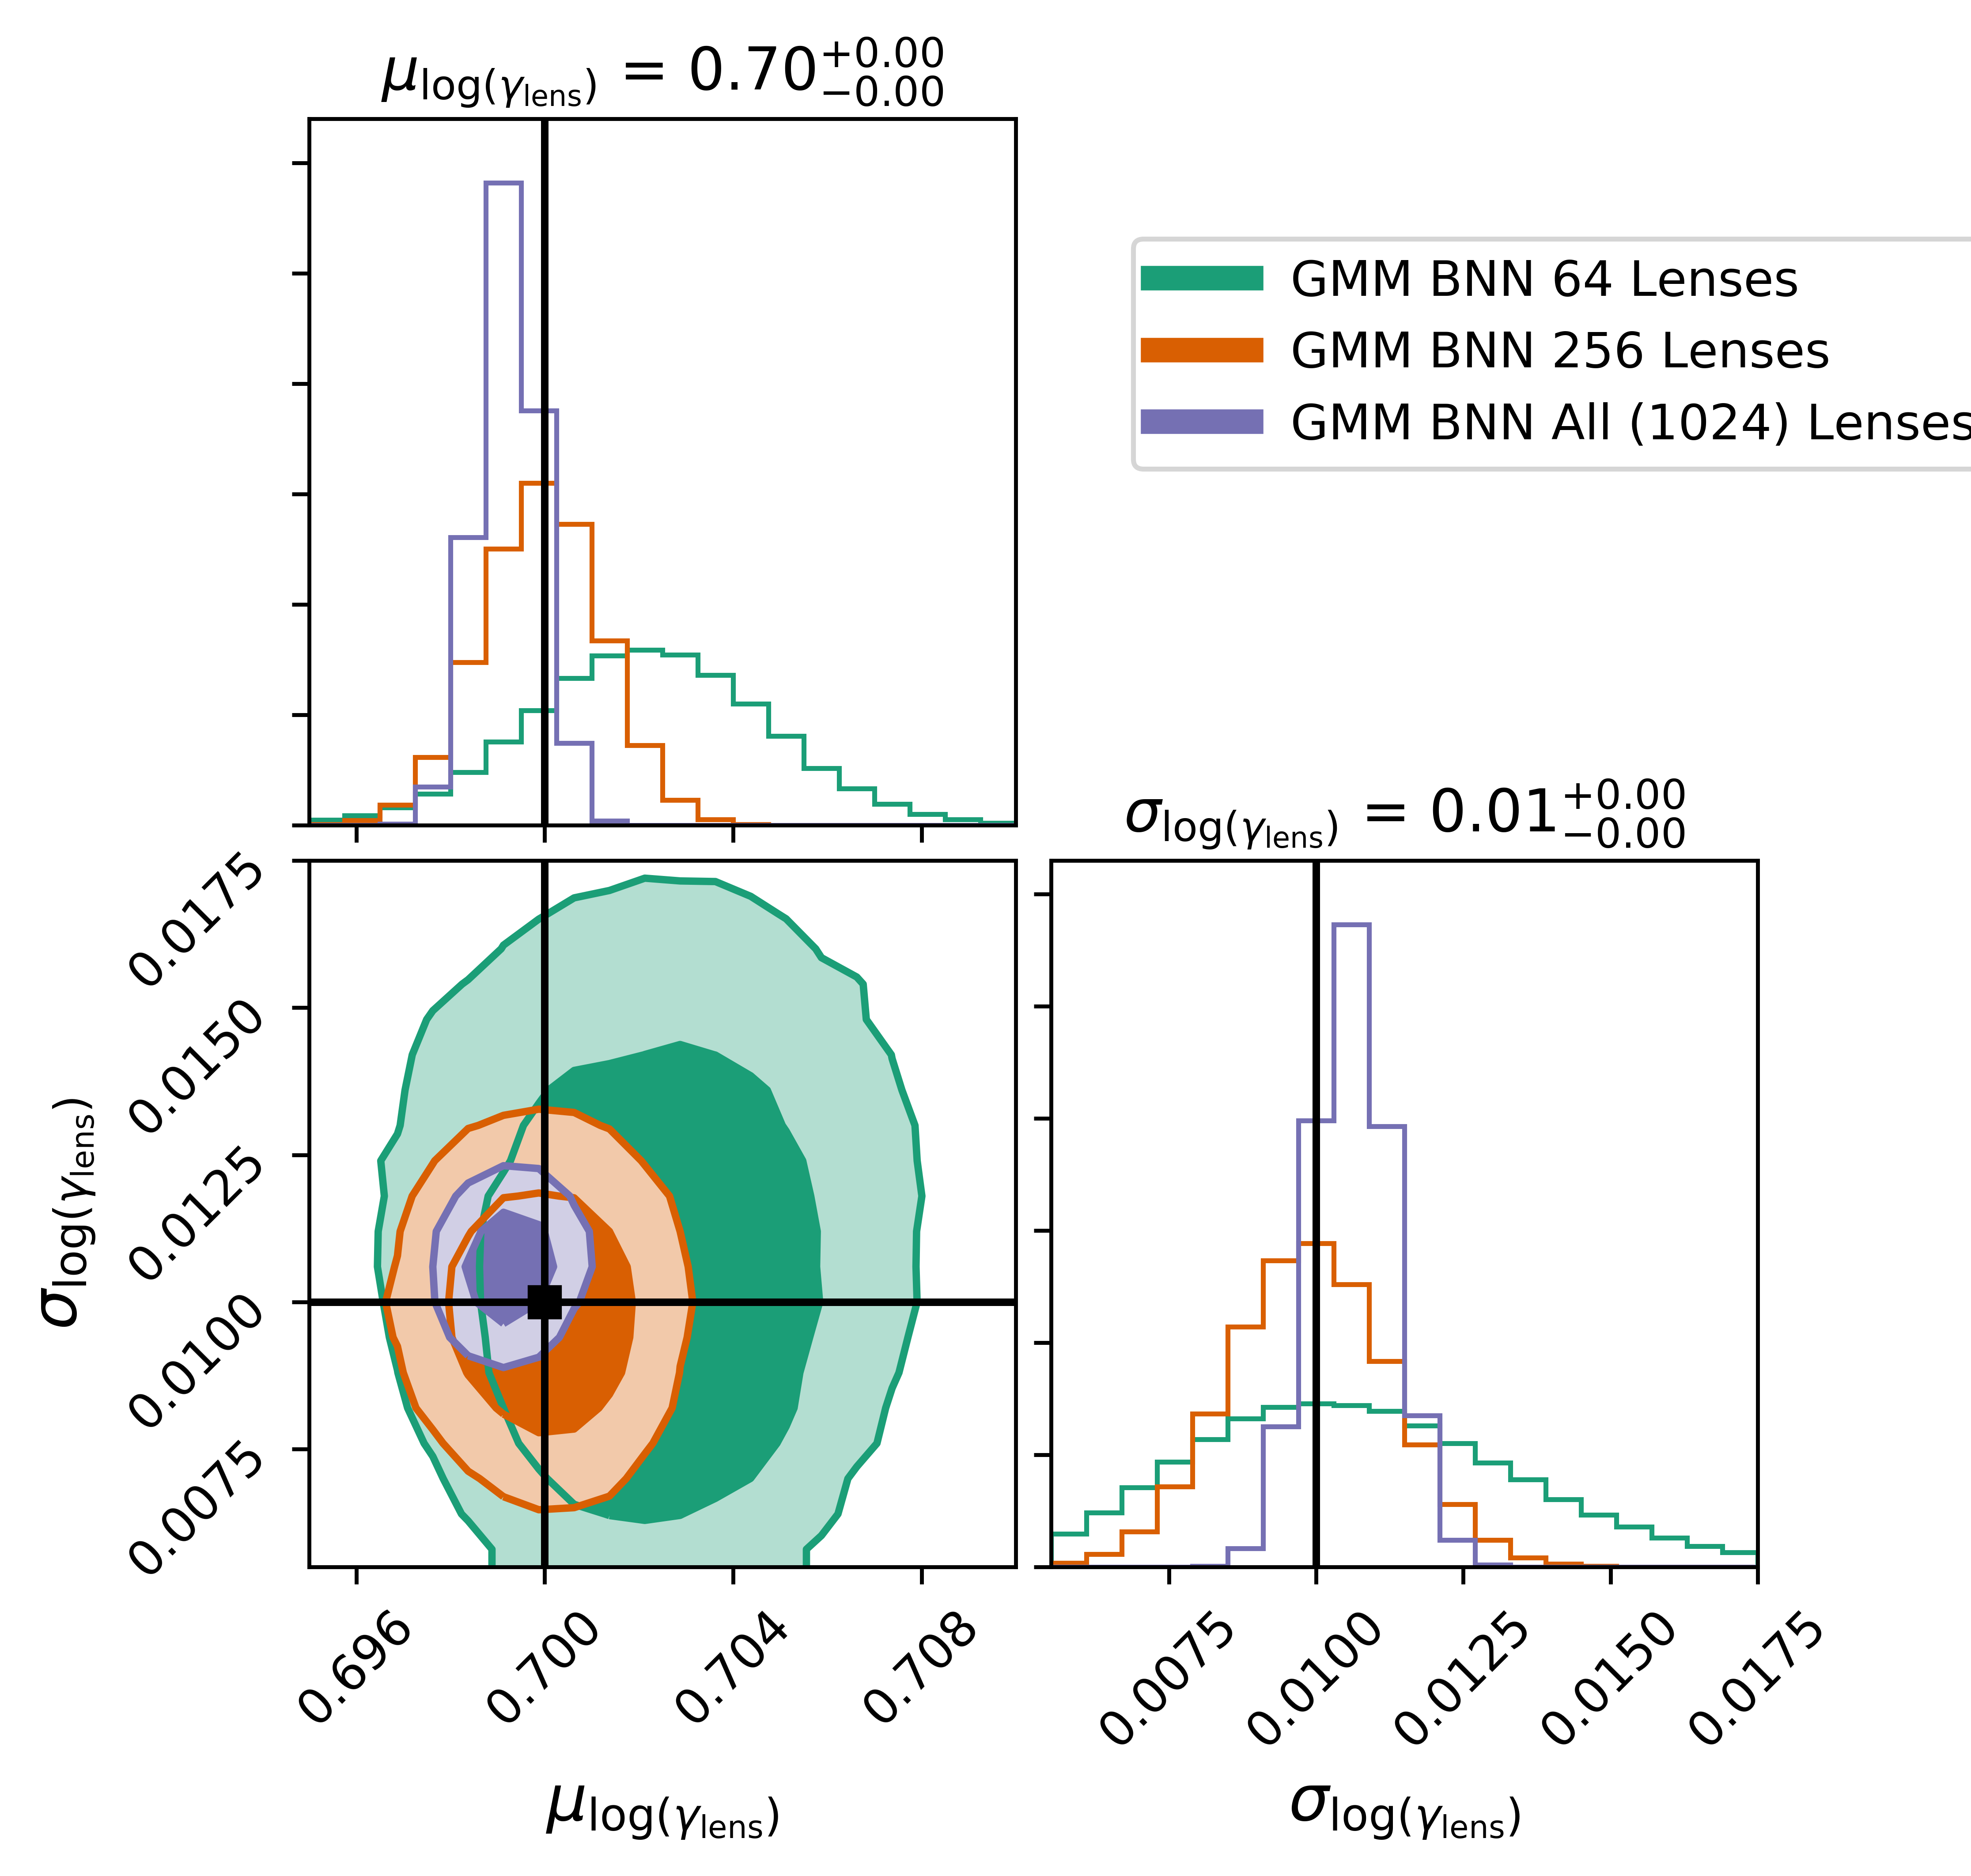

In [57]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
plot_range = [[0.695,0.71],[0.0055,0.0175]]
figure = hier_infer_nn3_slr_64.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr_256.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN 64 Lenses', r'GMM BNN 256 Lenses',r'GMM BNN All (1024) Lenses'],
              loc=(0.575,0.75))
plt.savefig('figures/cn_gamma_lens_2d_hyps_nl.pdf')
plt.show(figure)